### Question 1 code

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional

class LQR:
    
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor):
        """
        Initialize the LQR problem.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
        """
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        self.time_grid = time_grid
        
        # Check dimensions
        d, m = M.shape
        assert H.shape == (d, d), "H must be d x d"
        assert sigma.shape[0] == d, "sigma must be d x d'"
        assert C.shape == (d, d), "C must be d x d"
        assert D.shape == (m, m), "D must be m x m"
        assert R.shape == (d, d), "R must be d x d"
        
        # Store dimensions
        self.d = d
        self.m = m
        
        # Compute inverse of D once for efficiency
        self.D_inv = torch.inverse(D)
        
        # Initialize solution placeholders
        self.S_grid = None  # Will be populated when solve_ricatti is called
        self.int_term_grid = None  # Will store the integral term
        
    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the Ricatti ODE: S'(t) = S(t)MD^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side
        term1 = S @ self.M @ self.D_inv @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def solve_ricatti(self) -> None:
        """
        Solve the Ricatti ODE using scipy's solve_ivp for high accuracy.
        """
        # Convert matrices to double precision if they aren't already
        self.H = self.H.to(torch.float64)
        self.M = self.M.to(torch.float64)
        self.sigma = self.sigma.to(torch.float64)
        self.C = self.C.to(torch.float64)
        self.D = self.D.to(torch.float64)
        self.R = self.R.to(torch.float64)
        self.D_inv = self.D_inv.to(torch.float64)
        
        # Terminal condition: S(T) = R
        S_T_flat = self.R.flatten().numpy()
        
        # Time points for ODE solver (reversed for backward integration)
        t_points = self.time_grid.numpy()
        t_reversed = self.T - t_points[::-1]
        
        # Solve the ODE backward in time (from T to 0)
        solution = solve_ivp(
            lambda t, y: -self.ricatti_rhs(self.T - t, y),  # Negative for backward integration
            [0, self.T],
            S_T_flat,
            t_eval=t_reversed,
            method='RK45',
            rtol=1e-11,
            atol=1e-11
        )
        
        # Convert solution back to PyTorch tensors and reshape
        S_values = solution.y.T
        S_matrices = [S.reshape(self.d, self.d) for S in S_values]
        S_matrices.reverse()  # Reverse back to forward time
        
        self.S_grid = torch.tensor(S_matrices, dtype=torch.float64)
        
        # Compute integral term for value function
        self.compute_integral_term()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: int_t^T tr(sigma sigma^T S(r)) dr
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Compute trace term at each time point
        trace_terms = torch.zeros(len(self.time_grid))
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(len(self.time_grid)):
            trace_terms[i] = torch.trace(sigma_sigma_T @ self.S_grid[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid))
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        self.int_term_grid = integral_term
    
    def get_S_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the S matrix at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            S matrices at the specified times (batch x d x d)
        """
        if self.S_grid is None:
            self.solve_ricatti()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding S matrices
        return self.S_grid[indices]
    
    def get_integral_term_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the integral term at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Integral terms at the specified times (batch)
        """
        if self.int_term_grid is None:
            self.compute_integral_term()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding integral terms
        return self.int_term_grid[indices]
    
    def value_function(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the value function v(t, x) = x^T S(t) x + int_t^T tr(sigma sigma^T S(r)) dr
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute quadratic term x^T S(t) x
        batch_size = x.shape[0]
        values = torch.zeros(batch_size, device=x.device)
        
        for i in range(batch_size):
            values[i] = x[i] @ S_matrices[i] @ x[i]
        
        # Add integral term
        values = values + self.get_integral_term_at_time(t)
        
        return values
    
    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the optimal control a(t, x) = -D^(-1)M^TS(t)x
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Optimal control at (t, x) (batch x m)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute optimal control for each (t, x) pair
        batch_size = x.shape[0]
        controls = torch.zeros((batch_size, self.m), device=x.device)
        
        for i in range(batch_size):
            controls[i] = -self.D_inv @ self.M.T @ S_matrices[i] @ x[i]
        
        return controls
    
# Update the simulation functions to accept fixed noise
def simulate_sde_explicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int, 
                                   fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Optimized implementation of the explicit scheme SDE simulation using vectorization.
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, lqr.sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    # Ensure all matrices have consistent dtype (float64)
    H = lqr.H.to(dtype=torch.float64)
    M = lqr.M.to(dtype=torch.float64)
    sigma = lqr.sigma.to(dtype=torch.float64)
    C = lqr.C.to(dtype=torch.float64)
    D = lqr.D.to(dtype=torch.float64)
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        X_n = X[:, :, n, :]  # [num_samples, batch_size, d]
        
        # Reshape for batch processing
        X_n_flat = X_n.reshape(-1, d)  # [num_samples*batch_size, d]
        t_flat = torch.full((num_samples * batch_size,), t_n, dtype=torch.float64)
        
        # Compute optimal control
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(dtype=torch.float64)  # Explicitly convert to float64
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # Batch matrix multiplication for drift computation
        X_n_bmm = X_n.reshape(-1, d, 1)
        
        # Create expanded H matrix with explicit dtype
        H_expanded = H.unsqueeze(0).expand(num_samples*batch_size, -1, -1)
        
        # Compute HX
        HX = torch.bmm(H_expanded, X_n_bmm)
        
        # Reshape control and ensure correct dtype
        control_bmm = control.reshape(-1, lqr.m, 1).to(dtype=torch.float64)
        
        # Create expanded M matrix with explicit dtype
        M_expanded = M.unsqueeze(0).expand(num_samples*batch_size, -1, -1)
        
        # Compute Ma
        Ma = torch.bmm(M_expanded, control_bmm)
        
        # Compute drift = HX + Ma
        drift = (HX + Ma).squeeze(2).reshape(num_samples, batch_size, d)
        
        # Compute noise term
        sigma_expanded = sigma.unsqueeze(0).expand(num_samples*batch_size, -1, -1)
        dW_n_reshaped = dW[:, :, n, :].reshape(-1, sigma.shape[1], 1)
        noise_term = torch.bmm(sigma_expanded, dW_n_reshaped).reshape(num_samples, batch_size, d)
        
        # Update state using explicit scheme
        X[:, :, n+1] = X_n + drift * dt + noise_term
        
        # Compute costs
        state_costs = torch.einsum('ijk,kl,ijl->ij', X_n, C, X_n)
        control_costs = torch.einsum('ijk,kl,ijl->ij', control, D, control)
        costs += (state_costs + control_costs) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    terminal_costs = torch.einsum('ijk,kl,ijl->ij', X_T, lqr.R.to(dtype=torch.float64), X_T)
    costs += terminal_costs
    
    return X, costs

def simulate_sde_implicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int,
                                   fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Optimized implementation of the implicit scheme SDE simulation using vectorization.
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, lqr.sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    dW = dW.to(dtype=torch.float64)
    # Precompute matrices
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    D_inv = lqr.D_inv.to(torch.float64)
    
    # Identity matrix for linear system
    I = torch.eye(d, dtype=torch.float64)
    
    # Vectorize implicit scheme computation
    for n in range(num_steps):
        t_n = t_grid[n]
        t_np1 = t_grid[n+1]
        X_n = X[:, :, n, :]
        
        # Compute optimal control for cost calculation
        X_n_flat = X_n.reshape(-1, d)
        t_flat = torch.full((num_samples * batch_size,), t_n, dtype=torch.float64)
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(dtype=torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # Get S matrix for the next time step
        t_np1_tensor = torch.tensor([t_np1], dtype=torch.float64)
        S_np1 = lqr.get_S_at_time(t_np1_tensor)[0].to(dtype=torch.float64)
        
        # Construct system matrix: (I - dt*H + dt*M*D^(-1)*M^T*S(t_{n+1}))
        MD_inv_MT = M @ D_inv @ M.T
        A = I - dt * H + dt * MD_inv_MT @ S_np1
        
        # Use batch solve for all samples at once
        # First compute the right-hand side b = X_n + sigma * dW_n
        noise_term = torch.bmm(
            sigma.unsqueeze(0).expand(num_samples*batch_size, -1, -1),
            dW[:, :, n, :].reshape(-1, sigma.shape[1], 1)
        ).reshape(num_samples, batch_size, d)
        
        b = X_n + noise_term
        
        # Reshape for batch solver
        b_flat = b.reshape(-1, d)
        
        # Expand A for batch solve - this is more efficient for large batches than
        # solving each system individually
        A_expanded = A.unsqueeze(0).expand(num_samples*batch_size, -1, -1)
        
        # Solve the linear systems all at once
        # Using batched solve from torch
        X_np1_flat = torch.linalg.solve(A_expanded, b_flat.unsqueeze(2)).squeeze(2)
        X[:, :, n+1] = X_np1_flat.reshape(num_samples, batch_size, d)
        
        # Compute costs vectorized
        state_costs = torch.einsum('ijk,kl,ijl->ij', X_n, C, X_n)
        control_costs = torch.einsum('ijk,kl,ijl->ij', control, D, control)
        costs += (state_costs + control_costs) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    terminal_costs = torch.einsum('ijk,kl,ijl->ij', X_T, lqr.R.to(dtype=torch.float64), X_T)
    costs += terminal_costs
    
    return X, costs

def run_monte_carlo_comparison(lqr: LQR, x0: torch.Tensor) -> None:

    """
    Run Monte Carlo tests comparing explicit and implicit schemes on the same plots.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # 1. Test varying time steps with fixed number of samples
    num_samples = 1500 # Should be 10k
    time_steps_list = [2**i for i in range(1, 10)] # Should be 12
    
    # Compute true value function at t=0, x=x0
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    true_values = lqr.value_function(t0, x0)
    
    # Arrays to store results for both schemes
    explicit_time_errors = []
    implicit_time_errors = []
    
    print("\n--- Testing convergence for both schemes with varying time steps ---")
    
    for num_steps in time_steps_list:
        print(f"Running with {num_steps} time steps...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_time_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_time_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot time step convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(time_steps_list, explicit_time_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(time_steps_list, implicit_time_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference lines for O(1/N) and O(1/N²) convergence
    ref_line_order1 = [explicit_time_errors[0] * (time_steps_list[0] / n) for n in time_steps_list]
    ref_line_order2 = [explicit_time_errors[0] * (time_steps_list[0] / n)**2 for n in time_steps_list]
    
    plt.loglog(time_steps_list, ref_line_order1, '--', color='blue', alpha=0.5, label='O(1/N)')
    plt.loglog(time_steps_list, ref_line_order2, '--', color='red', alpha=0.5, label='O(1/N²)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Time Steps - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2. Test varying number of samples with fixed number of time steps
    num_steps = 1500  # Large number for accuracy should be 10k
    sample_counts = [2 * 4**i for i in range(5)] # Should be 6
    
    # Arrays to store results for both schemes
    explicit_sample_errors = []
    implicit_sample_errors = []
    
    print("\n--- Testing convergence for both schemes with varying sample counts ---")
    
    for num_samples in sample_counts:
        print(f"Running with {num_samples} samples...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_sample_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_sample_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot sample count convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_counts, explicit_sample_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(sample_counts, implicit_sample_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference line for O(1/sqrt(M)) convergence (Monte Carlo rate)
    ref_line_mc = [explicit_sample_errors[0] * np.sqrt(sample_counts[0] / n) for n in sample_counts]
    plt.loglog(sample_counts, ref_line_mc, '--', color='green', label='O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Sample Counts - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 4000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Solve Ricatti ODE
    lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("S(0):\n", lqr.S_grid[0])
    print("S(T/2):\n", lqr.S_grid[grid_size//2])
    print("S(T):\n", lqr.S_grid[-1])
    
    # Test points
    x0 = torch.tensor([
        [1.0, 1.0],
        [2.0, 2.0]
    ], dtype=torch.float64)
    
    # Compute value function at test points
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    v0 = lqr.value_function(t0, x0)
    print("\nValue function at t=0:")
    for i in range(x0.shape[0]):
        print(f"v(0, {x0[i].tolist()}) = {v0[i].item():.6f}")
    
    # Get the optimal control for the test points
    u0 = lqr.optimal_control(t0, x0)
    print("\nOptimal control at t=0:")
    for i in range(x0.shape[0]):
        print(f"u(0, {x0[i].tolist()}) = {u0[i].tolist()}")
    
    # Run Monte Carlo comparison for both schemes
    run_monte_carlo_comparison(lqr, x0)
    
    # Additionally, compare trajectories from both schemes
    compare_scheme_trajectories(lqr, x0)

def compare_scheme_trajectories(lqr: LQR, x0: torch.Tensor) -> None:
    """
    Compare and plot trajectories from explicit and implicit schemes.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # Set simulation parameters
    num_steps = 100
    num_samples = 1  # Just one sample for visualization
    
    # Simulate trajectories using both schemes with the same noise
    # Generate Brownian motion for consistency between schemes
    dt = lqr.T / num_steps
    dW = torch.randn((num_samples, x0.shape[0], num_steps, lqr.sigma.shape[1]), 
                    dtype=torch.float64) * np.sqrt(dt)
    
    # Run simulations with shared noise
    X_explicit, _ = simulate_sde_explicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    X_implicit, _ = simulate_sde_implicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    
    # Plot trajectories for each initial state
    fig, axes = plt.subplots(1, x0.shape[0], figsize=(15, 5))
    
    for i in range(x0.shape[0]):
        ax = axes[i] if x0.shape[0] > 1 else axes
        
        # Extract trajectories for this initial state
        traj_explicit = X_explicit[0, i].cpu().numpy()  # First sample, ith initial state
        traj_implicit = X_implicit[0, i].cpu().numpy()
        
        # Plot trajectories
        ax.plot(traj_explicit[:, 0], traj_explicit[:, 1], 'b-', label='Explicit Scheme')
        ax.plot(traj_implicit[:, 0], traj_implicit[:, 1], 'r-', label='Implicit Scheme')
        ax.scatter([x0[i, 0]], [x0[i, 1]], c='g', s=100, marker='o', label='Initial State')
        
        ax.set_title(f'Trajectories from Initial State {x0[i].tolist()}')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_25028\2675674214.py:114: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.S_grid = torch.tensor(S_matrices, dtype=torch.float64)


S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
S(T/2):
 tensor([[ 0.4914, -0.3260],
        [-0.3260,  0.7789]], dtype=torch.float64)
S(T):
 tensor([[10.,  3.],
        [ 3., 10.]], dtype=torch.float64)

Value function at t=0:
v(0, [1.0, 1.0]) = 0.782116
v(0, [2.0, 2.0]) = 2.380299

Optimal control at t=0:
u(0, [1.0, 1.0]) = [-1.2770086526870728, -5.199576377868652]
u(0, [2.0, 2.0]) = [-2.5540173053741455, -10.399152755737305]

--- Testing convergence for both schemes with varying time steps ---
Running with 2 time steps...
  Explicit scheme error: 4.955815
  Implicit scheme error: 2.354963
Running with 4 time steps...
  Explicit scheme error: 1.102173
  Implicit scheme error: 1.086054
Running with 8 time steps...
  Explicit scheme error: 0.481637
  Implicit scheme error: 0.490232
Running with 16 time steps...
  Explicit scheme error: 0.212768
  Implicit scheme error: 0.210776
Running with 32 time steps...
  Explicit scheme error: 0.104127
  Implic

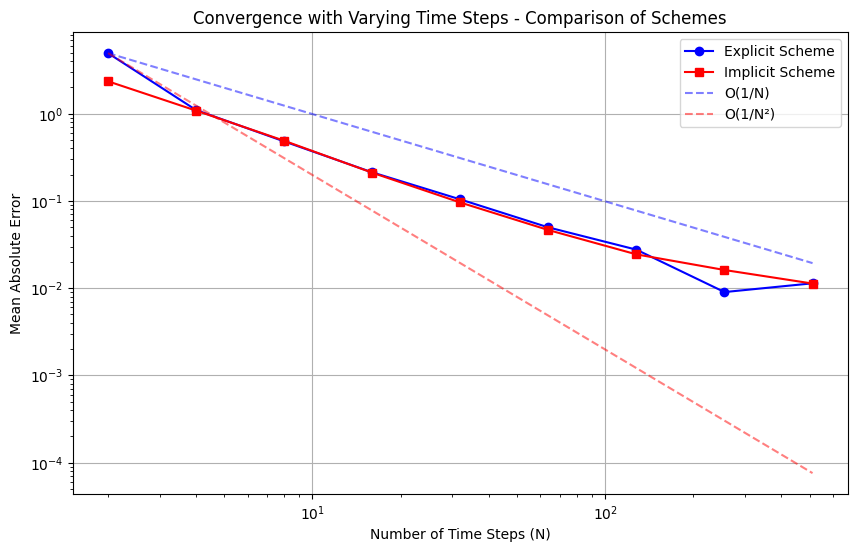


--- Testing convergence for both schemes with varying sample counts ---
Running with 2 samples...
  Explicit scheme error: 0.056684
  Implicit scheme error: 0.029149
Running with 8 samples...
  Explicit scheme error: 0.017108
  Implicit scheme error: 0.055815
Running with 32 samples...
  Explicit scheme error: 0.030390
  Implicit scheme error: 0.056262
Running with 128 samples...
  Explicit scheme error: 0.011316
  Implicit scheme error: 0.015621
Running with 512 samples...
  Explicit scheme error: 0.006494
  Implicit scheme error: 0.013668


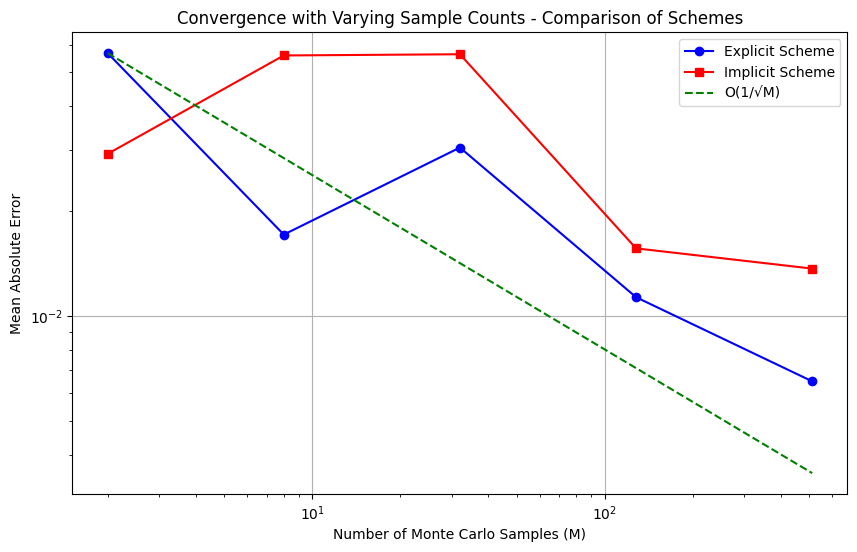

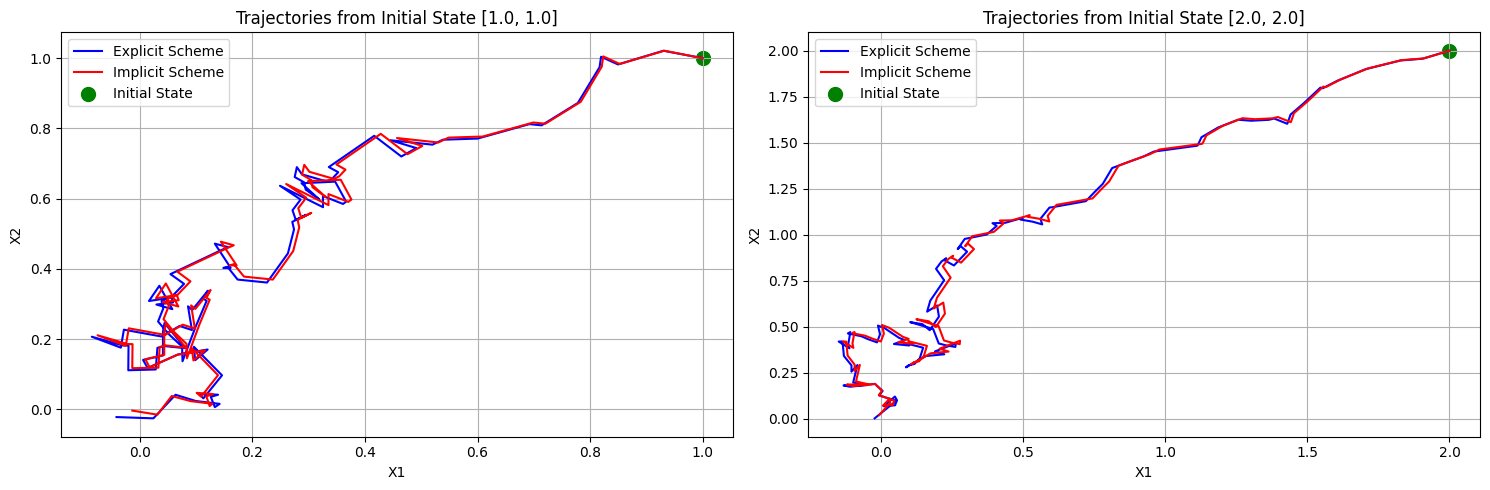

In [2]:
main()

### Question 2 code

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional
import math

class SoftLQR(LQR):
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor,
                 tau: float, gamma: float):
        """
        Initialize the soft LQR problem with entropy regularization.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
            tau: Entropy regularization strength
            gamma: Variance of prior normal density
        """
        super().__init__(H, M, sigma, C, D, R, T, time_grid)
        
        # Store additional parameters
        self.tau = tau
        self.gamma = gamma
        
        # Compute modified inverse term for the soft LQR
        # Σ⁻¹ = D + τ/(2γ²)I
        self.sigma_inv = self.D + (tau / (2 * gamma**2)) * torch.eye(self.m, dtype=self.D.dtype, device=self.D.device)
        self.sigma_term = torch.inverse(self.sigma_inv)
        
        # Compute determinant term for value function
        # C_D,τ,γ = -τ ln(τ^(m/2)/(γ^m * det(Σ)^(1/2)))
        self.CD_tau_gamma = -tau * math.log((tau**(self.m/2)) / (gamma**self.m * torch.sqrt(torch.det(self.sigma_term)).item()))

    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the modified Ricatti ODE for soft LQR:
        S'(t) = S(t)M(D + τ/(2γ²)I)^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side with modified term
        term1 = S @ self.M @ self.sigma_term @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: 
        int_t^T tr(sigma sigma^T S(r)) dr + (T-t) * C_D,τ,γ
        
        Vectorized implementation with type checking.
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Precompute sigma_sigma_T
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        # Check if S_grid is already a tensor or a list
        if not isinstance(self.S_grid, torch.Tensor):
            # Convert S_grid list to a tensor if it's not already a tensor
            S_grid_tensor = torch.stack(self.S_grid)
        else:
            # If it's already a tensor, just use it directly
            S_grid_tensor = self.S_grid
        
        # Ensure it has the right shape [time_steps, d, d]
        if len(S_grid_tensor.shape) < 3:
            # If S_grid_tensor is of shape [time_steps*d, d], reshape it
            time_steps = len(self.time_grid)
            S_grid_tensor = S_grid_tensor.reshape(time_steps, self.d, self.d)
        
        # Vectorized trace computation
        # For each S matrix, compute tr(sigma_sigma_T @ S)
        # Need to make sure dimensions match for batch matrix multiplication
        trace_terms = torch.zeros(len(self.time_grid), dtype=torch.float64, device=S_grid_tensor.device)
        
        for i in range(len(self.time_grid)):
            # Computing trace for each time step separately is safer than a full batch operation
            # This avoids potential shape mismatch issues
            trace_terms[i] = torch.trace(sigma_sigma_T @ S_grid_tensor[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid), dtype=torch.float64, device=S_grid_tensor.device)
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        # Add the constant term proportional to (T-t)
        for i in range(len(self.time_grid)):
            integral_term[i] += (self.T - self.time_grid[i]) * self.CD_tau_gamma
        
        self.int_term_grid = integral_term
    
    def optimal_control_distribution(self, t: torch.Tensor, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the parameters of the optimal control distribution:
        π*(·|t, x) = N(-(D + τ/(2γ²)I)^(-1)M^TS(t)x, τ(D + τ/(2γ²)I))
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Tuple of (mean, covariance) of optimal control distribution
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute mean for each (t, x) pair
        batch_size = x.shape[0]
        means = torch.zeros((batch_size, self.m), dtype=torch.float64, device=x.device)
        
        # Process each input individually
        for i in range(batch_size):
            # Extract S matrix and ensure it has the correct shape (d x d)
            S = S_matrices[i]
            
            # Check if S has the wrong shape - it might be the full time grid
            if S.shape[0] != self.d:
                # This means we're getting the entire S grid instead of a single matrix
                # Take just the relevant matrix for this time point
                # Find the closest time index
                t_val = t[i].item()
                idx = torch.argmin(torch.abs(self.time_grid - t_val)).item()
                S = self.S_grid[idx]  # Get the matrix at this time point
            
            # Ensure S is the correct shape (d x d)
            if S.shape != (self.d, self.d):
                # Create a proper S matrix
                proper_S = torch.eye(self.d, dtype=torch.float64, device=S.device)
                # Copy values if possible
                rows = min(S.shape[0], self.d)
                cols = min(S.shape[1], self.d)
                proper_S[:rows, :cols] = S[:rows, :cols]
                S = proper_S
            
            # Make x[i] a column vector - handle both 1D and 2D inputs
            if x[i].dim() == 1:
                x_col = x[i].reshape(self.d, 1)
            else:
                x_col = x[i].reshape(-1, 1)
                
            # Explicitly compute the matrix multiplications step by step
            # 1. S @ x_col: [d,d] @ [d,1] = [d,1]
            step1 = S @ x_col
            
            # 2. M.T @ step1: [m,d] @ [d,1] = [m,1]
            step2 = self.M.T @ step1
            
            # 3. sigma_term @ step2: [m,m] @ [m,1] = [m,1]
            mean_col = -self.sigma_term @ step2
            
            # Flatten to 1D tensor and ensure it has the right size
            if mean_col.shape[0] == self.m:
                means[i] = mean_col.reshape(self.m)
            else:
                # Handle unexpected size by creating zeros
                means[i] = torch.zeros(self.m, dtype=torch.float64, device=means.device)
        
        # The covariance is constant for all (t, x)
        covariance = self.tau * self.sigma_term
        
        return means, covariance

    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Sample from the optimal control distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Sampled control actions (batch x m)
        """
        means, covariance = self.optimal_control_distribution(t, x)
        
        # Create multivariate normal distribution
        batch_size = means.shape[0]
        samples = torch.zeros_like(means)
        
        # Sample from the distribution
        # Use Cholesky decomposition for numerical stability
        try:
            L = torch.linalg.cholesky(covariance)  # Lower triangular Cholesky factor
            
            # Generate samples individually to avoid batch errors
            for i in range(batch_size):
                # Generate standard normal samples
                z = torch.randn(self.m, dtype=torch.float64, device=means.device)
                # Transform to multivariate normal with the required covariance
                samples[i] = means[i] + L @ z
                
        except Exception as e:
            # Fallback approach if Cholesky decomposition fails
            print(f"Warning: Cholesky decomposition failed, using alternative sampling: {e}")
            for i in range(batch_size):
                # Generate using independent normal samples
                samples[i] = means[i] + torch.sqrt(torch.diag(covariance)) * torch.randn(self.m, dtype=torch.float64, device=means.device)
        
        return samples
    
def simulate_comparison(lqr: LQR, soft_lqr: SoftLQR, x0_list: list, num_steps: int, scheme: str = 'explicit') -> None:
    """
    Simulate and compare the standard LQR and soft LQR trajectories.
    
    Args:
        lqr: Standard LQR instance
        soft_lqr: Soft LQR instance
        x0_list: List of initial states to test
        num_steps: Number of time steps
        scheme: 'explicit' or 'implicit'
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    # Ensure all matrices are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    R = lqr.R.to(torch.float64)
    
    # Initialize plot
    fig, axes = plt.subplots(len(x0_list), 2, figsize=(16, 4*len(x0_list)), squeeze=False)
    
    for i, x0 in enumerate(x0_list):
        # Convert initial state to tensor with explicit dtype
        x0_tensor = torch.tensor([x0], dtype=torch.float64)
        
        # Initialize trajectories and costs
        X_lqr = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_soft = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_lqr[0] = x0_tensor[0]
        X_soft[0] = x0_tensor[0]
        
        costs_lqr = torch.zeros(1, dtype=torch.float64)
        costs_soft = torch.zeros(1, dtype=torch.float64)
        
        # Generate same Brownian increments for both simulations
        dW = torch.randn((num_steps, sigma.shape[1]), dtype=torch.float64) * np.sqrt(dt)
        
        # For cost tracking
        running_costs_lqr = torch.zeros(num_steps + 1, dtype=torch.float64)
        running_costs_soft = torch.zeros(num_steps + 1, dtype=torch.float64)
        
        # Simulate trajectories
        if scheme == 'explicit':
            # Explicit scheme
            for n in range(num_steps):
                t_n = t_grid[n]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                
                # Standard LQR step
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                drift_lqr = H @ X_lqr[n].to(torch.float64) + M @ control_lqr[0]
                X_lqr[n+1] = X_lqr[n] + drift_lqr * dt + sigma @ dW[n]
                
                # Compute running cost for LQR - using scalar operations to avoid dtype issues
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR step
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                drift_soft = H @ X_soft[n].to(torch.float64) + M @ control_soft[0]
                X_soft[n+1] = X_soft[n] + drift_soft * dt + sigma @ dW[n]
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        else:
            # Implicit scheme
            # Identity matrix for linear system
            I = torch.eye(2, dtype=torch.float64)
            
            for n in range(num_steps):
                t_n = t_grid[n]
                t_np1 = t_grid[n+1]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                t_np1_tensor = torch.tensor([t_np1], dtype=torch.float64)
                
                # Standard LQR
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                S_np1_lqr = lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                D_inv_float64 = lqr.D_inv.to(torch.float64)
                A_lqr = I - dt * H + dt * M @ D_inv_float64 @ M.T @ S_np1_lqr
                b_lqr = X_lqr[n] + sigma @ dW[n]
                X_lqr[n+1] = torch.linalg.solve(A_lqr, b_lqr)
                
                # Compute running cost for LQR
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                S_np1_soft = soft_lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                sigma_term_float64 = soft_lqr.sigma_term.to(torch.float64)
                A_soft = I - dt * H + dt * M @ sigma_term_float64 @ M.T @ S_np1_soft
                b_soft = X_soft[n] + sigma @ dW[n]
                X_soft[n+1] = torch.linalg.solve(A_soft, b_soft)
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        
        # Add terminal costs
        X_lqr_T = X_lqr[-1].to(torch.float64)
        X_soft_T = X_soft[-1].to(torch.float64)
        R_float64 = R.to(torch.float64)
        
        terminal_cost_lqr = torch.matmul(torch.matmul(X_lqr_T, R_float64), X_lqr_T).item()
        terminal_cost_soft = torch.matmul(torch.matmul(X_soft_T, R_float64), X_soft_T).item()
        
        running_costs_lqr[-1] += terminal_cost_lqr
        running_costs_soft[-1] += terminal_cost_soft
        
        # Total final costs
        costs_lqr = running_costs_lqr[-1]
        costs_soft = running_costs_soft[-1]
        
        # Plot trajectories
        ax1 = axes[i, 0] if len(x0_list) > 1 else axes[0]
        ax1.plot(X_lqr[:, 0].numpy(), X_lqr[:, 1].numpy(), 'b-', label='Standard LQR')
        ax1.plot(X_soft[:, 0].numpy(), X_soft[:, 1].numpy(), 'r-', label='Soft LQR')
        ax1.scatter([x0[0]], [x0[1]], color='g', s=100, marker='o', label='Initial State')
        ax1.set_title(f'Trajectories from Initial State {x0}')
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.grid(True)
        ax1.legend()
        
        # Plot costs over time
        ax2 = axes[i, 1] if len(x0_list) > 1 else axes[1]
        ax2.plot(t_grid.numpy(), running_costs_lqr.numpy(), 'b-', label='Standard LQR Cost')
        ax2.plot(t_grid.numpy(), running_costs_soft.numpy(), 'r-', label='Soft LQR Cost')
        ax2.set_title(f'Cost Over Time from Initial State {x0}')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Cost')
        ax2.grid(True)
        ax2.legend()
        
        print(f"Initial state {x0}:")
        print(f"  Standard LQR final cost: {float(costs_lqr):.2f}")
        print(f"  Soft LQR final cost: {float(costs_soft):.2f}")
    
    plt.tight_layout()
    plt.show()

def main_soft_lqr():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.1
    gamma = 10.0
    
    # Create standard LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Create soft LQR instance
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODEs
    lqr.solve_ricatti()
    soft_lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("Standard LQR S(0):\n", lqr.S_grid[0])
    print("Soft LQR S(0):\n", soft_lqr.S_grid[0])
    
    # Test points for trajectory comparison
    initial_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    
    # Compare trajectories
    simulate_comparison(lqr, soft_lqr, initial_states, num_steps=200, scheme='explicit')

    

C:\Users\PC\AppData\Local\Temp\ipykernel_2360\704411625.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.S_grid = torch.tensor(S_matrices, dtype=torch.float64)


Standard LQR S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
Soft LQR S(0):
 tensor([[ 0.3711, -0.1911],
        [-0.1911,  0.5454]], dtype=torch.float64)
Initial state [2.0, 2.0]:
  Standard LQR final cost: 2.90
  Soft LQR final cost: 3.16
Initial state [2.0, -2.0]:
  Standard LQR final cost: 5.04
  Soft LQR final cost: 5.29
Initial state [-2.0, -2.0]:
  Standard LQR final cost: 2.78
  Soft LQR final cost: 3.01
Initial state [-2.0, 2.0]:
  Standard LQR final cost: 6.79
  Soft LQR final cost: 7.03


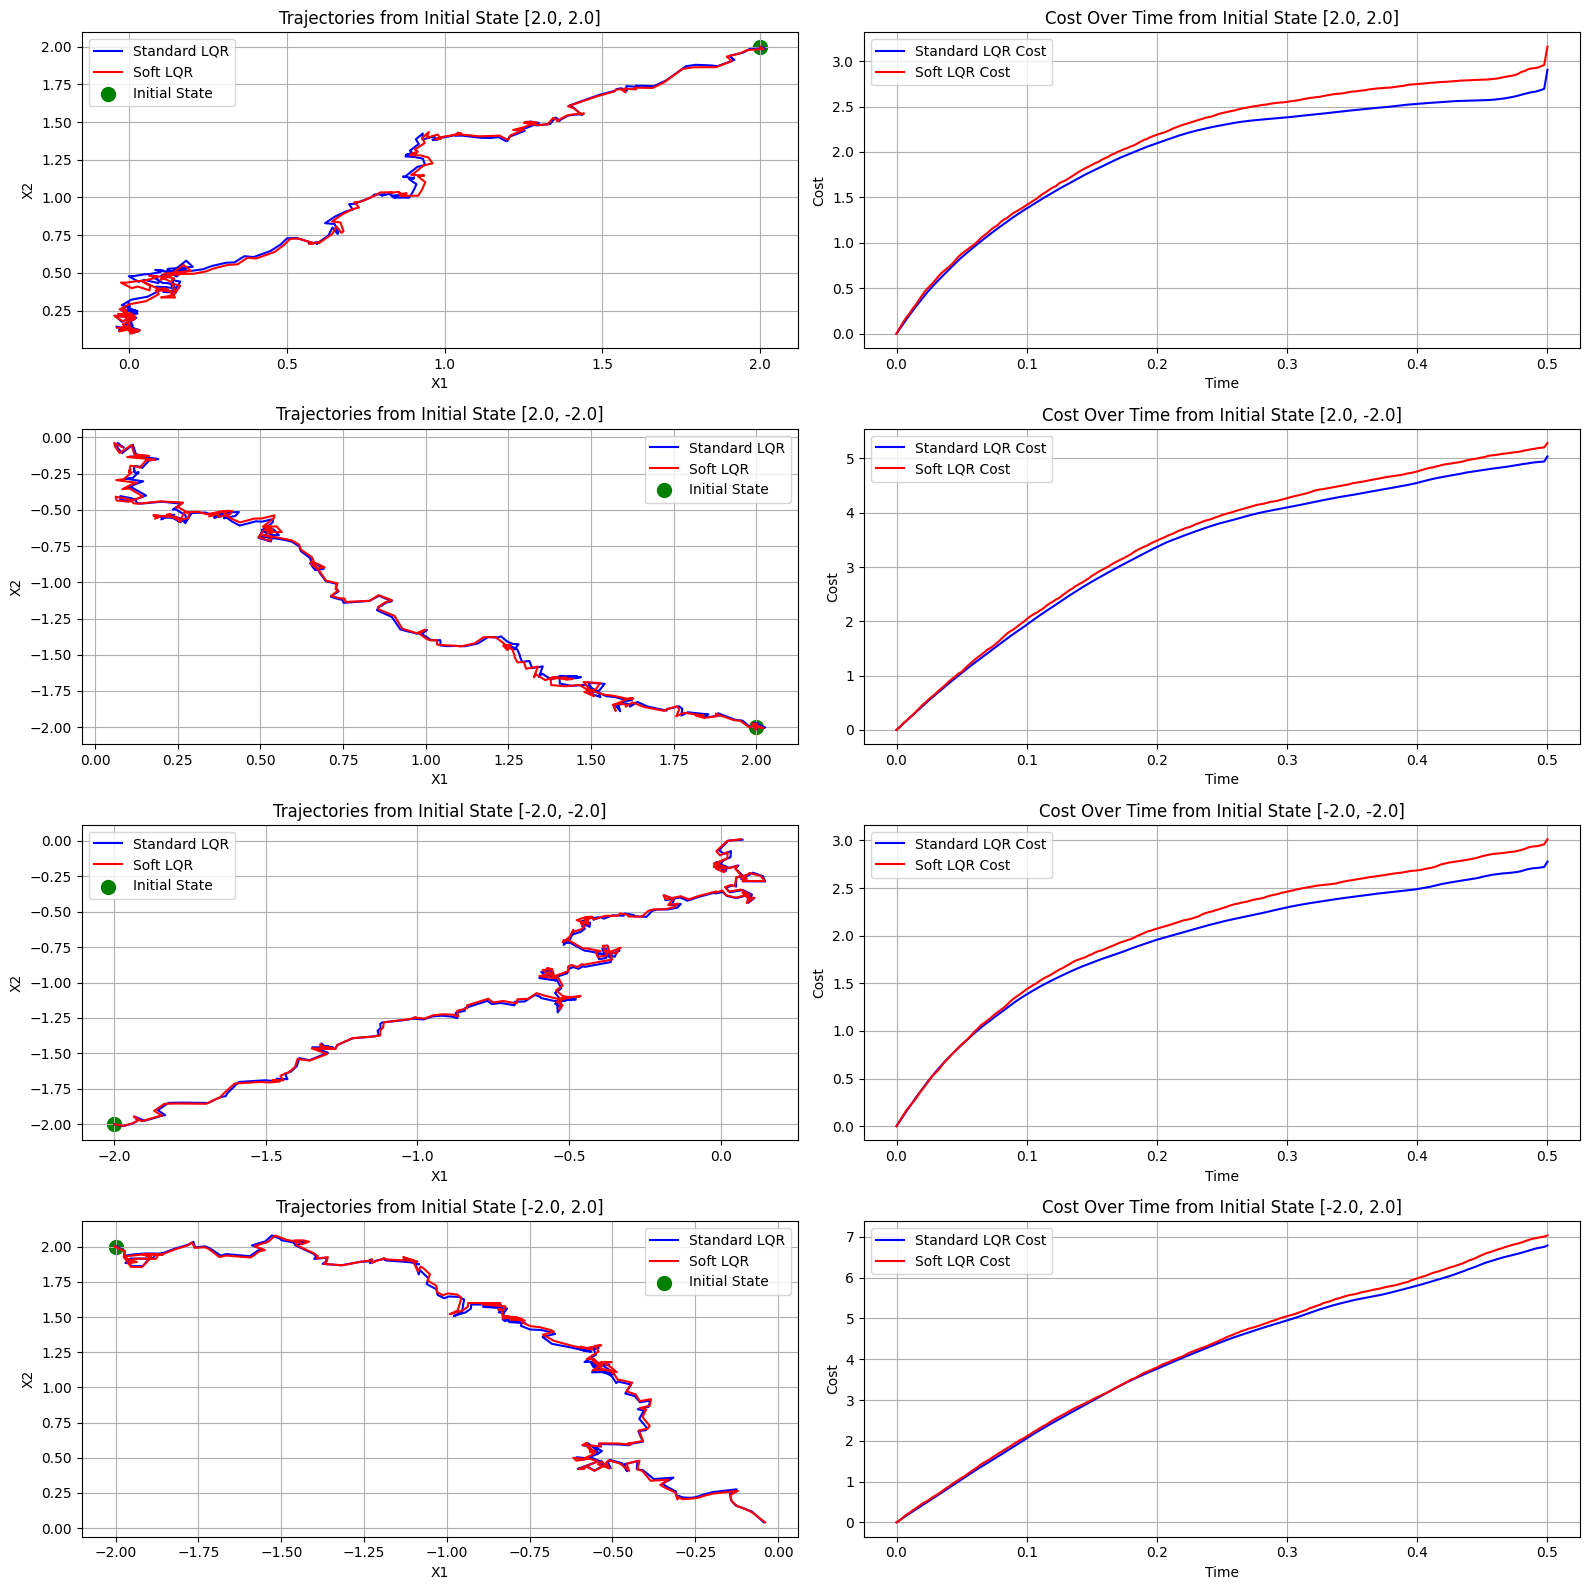

In [3]:
main_soft_lqr()

## Question 3

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

class ValueNN(nn.Module):
    """Neural network to approximate the value function for soft LQR.
    The value function is parameterized as v(t,x) = x^T K(t)x + R(t)."""
    
    def __init__(self, hidden_size=512, device=torch.device("cpu")):
        super(ValueNN, self).__init__()
        self.device = device
        
        # Explicitly set dtype for all layers
        dtype = torch.float64
        
        self.time_embedding = nn.Linear(1, hidden_size, device=device, dtype=dtype)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size, device=device, dtype=dtype)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size, device=device, dtype=dtype)
        self.matrix_output = nn.Linear(hidden_size, 2*2, device=device, dtype=dtype)
        self.offset_output = nn.Linear(hidden_size, 1, device=device, dtype=dtype)
    
    def forward(self, t):
        """
        Forward pass through the network.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Tuple of (matrix, offset) for value function approximation
        """
        # Ensure t is properly shaped
        t = t.view(-1, 1)
        
        # Forward pass through time embedding and hidden layers
        x = torch.relu(self.time_embedding(t))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        
        # Get matrix elements and reshape to batch of 2x2 matrices
        matrix_elements = self.matrix_output(x)
        batch_matrices = matrix_elements.view(-1, 2, 2)
        
        # Make the matrices positive semi-definite (symmetric and positive)
        matrices = torch.matmul(batch_matrices, batch_matrices.transpose(1, 2))
        matrices = matrices + 1e-3 * torch.eye(2, device=self.device).unsqueeze(0)
        
        # Get offset term
        offset = self.offset_output(x)
        
        return matrices, offset
    
    def value_function(self, t, x):
        """
        Compute the value function v(t,x) = x^T K(t)x + R(t) using vectorized operations.
        
        Args:
            t: Time tensor (batch) 
            x: State tensor (batch x 2)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Ensure consistent dtypes
        t = t.to(torch.float64)
        x = x.to(torch.float64)
        
        matrices, offsets = self.forward(t)
        
        # Ensure matrices and offsets are float64
        matrices = matrices.to(torch.float64)
        offsets = offsets.to(torch.float64)
        
        # Vectorized computation of quadratic term x^T K(t)x
        # Reshape x to [batch, 2, 1] for batch matrix multiplication
        x_reshaped = x.unsqueeze(2)  # [batch, 2, 1]
        
        # Compute x^T K(t)x for all batch elements at once:
        # First multiply matrices by x: [batch, 2, 2] @ [batch, 2, 1] -> [batch, 2, 1]
        # Then multiply x^T by the result: [batch, 1, 2] @ [batch, 2, 1] -> [batch, 1, 1]
        quadratic_terms = torch.bmm(
            torch.bmm(x_reshaped.transpose(1, 2), matrices), 
            x_reshaped
        ).squeeze(2).squeeze(1)  # Remove extra dimensions to get [batch]
        
        # Add offset term
        values = quadratic_terms + offsets.squeeze()
        
        return values


class CriticAlgorithm:
    """Implementation of the critic algorithm for soft LQR."""
    
    def __init__(self, 
                 soft_lqr: SoftLQR, 
                 hidden_size: int = 512, 
                 learning_rate: float = 1e-3,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the critic algorithm.
        """
        self.soft_lqr = soft_lqr
        self.device = device
        
        # Create value network - explicitly set dtype to float64
        self.value_network = ValueNN(hidden_size=hidden_size, device=device).to(device)
        
        # Convert network parameters to double precision
        for param in self.value_network.parameters():
            param.data = param.data.to(torch.float64)
        
        # Create optimizer
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=learning_rate)
        
        # MSE loss function
        self.criterion = nn.MSELoss()
        
        # For tracking progress
        self.loss_history = []
    
    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """Generate a batch of random states and times for training."""
        # Sample times uniformly from [0, T] - explicitly specify dtype
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        
        # Sample states uniformly from [-state_range, state_range]^2
        states = (torch.rand(batch_size, 2, device=self.device, dtype=torch.float64) * 2 - 1) * state_range
        
        return times, states
    
    def _compute_target_values(self, t: torch.Tensor, x: torch.Tensor, num_steps: int = 100) -> torch.Tensor:
        """
        Compute target values for critic training by simulating trajectories using the current policy.
        Vectorized implementation to process all batch elements simultaneously.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            num_steps: Number of time steps for simulation
            
        Returns:
            Target values tensor (batch)
        """
        batch_size = t.shape[0]
        device = self.device
        dtype = torch.float64
        
        # Initialize target values tensor
        target_values = torch.zeros(batch_size, device=device, dtype=dtype)
        
        # Handle states at terminal time directly (vectorized)
        terminal_mask = (t >= self.soft_lqr.T - 1e-6)
        if terminal_mask.any():
            x_terminal = x[terminal_mask]
            
            # Vectorized computation of terminal cost x^T R x
            x_term_reshaped = x_terminal.unsqueeze(2)  # [batch, 2, 1]
            R_tensor = self.soft_lqr.R.to(dtype).unsqueeze(0).expand(x_terminal.size(0), -1, -1)
            
            terminal_costs = torch.bmm(
                torch.bmm(x_term_reshaped.transpose(1, 2), R_tensor),
                x_term_reshaped
            ).squeeze()
            
            target_values[terminal_mask] = terminal_costs
        
        # Process non-terminal states
        non_terminal_mask = ~terminal_mask
        if not non_terminal_mask.any():
            return target_values
            
        # Extract non-terminal states for batch processing
        t_batch = t[non_terminal_mask]
        x_batch = x[non_terminal_mask]
        non_term_batch_size = t_batch.size(0)
        
        # Compute remaining time and step size
        remaining_time = self.soft_lqr.T - t_batch
        dt = remaining_time / num_steps
        
        # Initialize current states and costs
        states = x_batch.clone()
        costs = torch.zeros(non_term_batch_size, device=device, dtype=dtype)
        
        # Pre-allocate tensors for matrix operations to avoid repeated creation
        C_tensor = self.soft_lqr.C.to(dtype).unsqueeze(0).expand(non_term_batch_size, -1, -1)
        D_tensor = self.soft_lqr.D.to(dtype).unsqueeze(0).expand(non_term_batch_size, -1, -1)
        R_tensor = self.soft_lqr.R.to(dtype).unsqueeze(0).expand(non_term_batch_size, -1, -1)
        H_tensor = self.soft_lqr.H.to(dtype).unsqueeze(0).expand(non_term_batch_size, -1, -1)
        M_tensor = self.soft_lqr.M.to(dtype).unsqueeze(0).expand(non_term_batch_size, -1, -1)
        
        
        # Simulate all trajectories together
        for step in range(num_steps):
            # Current time for all batch elements
            current_time = t_batch + step * dt
            current_time_tensor = current_time.unsqueeze(1)  # Ensure proper shape
            
            # Get control distribution parameters
            means, covariance = self.soft_lqr.optimal_control_distribution(current_time_tensor, states)
            means = means.to(dtype)
            covariance = covariance.to(dtype)
            
            # Vectorized sampling from multivariate normal distribution
            L = torch.linalg.cholesky(covariance)  # Calculate Cholesky once
            
            # Generate random samples for all batch elements
            z = torch.randn(non_term_batch_size, self.soft_lqr.m, device=device, dtype=dtype)
            
            # Apply transformation to all samples: mean + L @ z
            controls = means + torch.bmm(
                L.unsqueeze(0).expand(non_term_batch_size, -1, -1), 
                z.unsqueeze(2)
            ).squeeze(2)
            
            # Vectorized computation of state costs using batch matrix multiplication
            states_reshaped = states.unsqueeze(2)  # [batch, 2, 1]
            state_costs = torch.bmm(
                torch.bmm(states_reshaped.transpose(1, 2), C_tensor),
                states_reshaped
            ).squeeze()
            
            # Vectorized computation of control costs
            controls_reshaped = controls.unsqueeze(2)  # [batch, 2, 1]
            control_costs = torch.bmm(
                torch.bmm(controls_reshaped.transpose(1, 2), D_tensor),
                controls_reshaped
            ).squeeze()
            
            # Entropy term calculation (same for all states if covariance is constant)
            entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)) / 2
            entropy_terms = torch.ones(non_term_batch_size, device=device, dtype=dtype) * entropy_term
            
            # Accumulate costs with proper broadcasting
            dt_expanded = dt.unsqueeze(-1) if dt.dim() == 1 else dt
            costs += (state_costs + control_costs + entropy_terms) * dt
            
            # Vectorized state update using Euler step
            # Calculate drift: HX + Mα
            drift = torch.bmm(states.unsqueeze(1), H_tensor.transpose(1, 2)).squeeze(1) + \
                torch.bmm(controls.unsqueeze(1), M_tensor.transpose(1, 2)).squeeze(1)
            
            # Generate random noise for all states at once
            noise = torch.randn(non_term_batch_size, self.soft_lqr.sigma.shape[1], 
                            device=device, dtype=dtype)
            diffusion = torch.matmul(noise, self.soft_lqr.sigma.T) * torch.sqrt(dt.unsqueeze(-1))
            
            # Update all states in parallel
            states = states + drift * dt.unsqueeze(-1) + diffusion
        
        # Vectorized calculation of terminal costs
        states_reshaped = states.unsqueeze(2)  # [batch, 2, 1]
        terminal_costs = torch.bmm(
            torch.bmm(states_reshaped.transpose(1, 2), R_tensor),
            states_reshaped
        ).squeeze()
        costs += terminal_costs
        
        # Assign costs to target values
        target_values[non_terminal_mask] = costs
        
        return target_values

    def train_step(self, batch_size: int) -> float:
        """Perform one training step of the critic algorithm."""
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute target values
        with torch.no_grad():
            target_values = self._compute_target_values(times, states)
        
        # Compute predicted values
        predicted_values = self.value_network.value_function(times, states)
        
        # Ensure consistent dtype before computing loss
        predicted_values = predicted_values.to(torch.float64)
        target_values = target_values.to(torch.float64)
        
        # Compute loss
        loss = self.criterion(predicted_values, target_values)
        
        # Perform optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, num_epochs: int, batch_size: int, 
              eval_interval: int = 10, eval_grid_size: int = 5) -> None:
        """
        Train the critic network.
        
        Args:
            num_epochs: Number of training epochs
            batch_size: Batch size for training
            eval_interval: Interval for evaluation
            eval_grid_size: Grid size for evaluation
        """
        print("Starting critic training...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            loss = self.train_step(batch_size)
            self.loss_history.append(loss)
            
            if (epoch + 1) % eval_interval == 0 or epoch == 0:
                # Evaluate current performance
                max_error = self.evaluate(eval_grid_size)
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6e}, Max Error: {max_error:.6e}, Time: {elapsed:.2f}s")
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    
    def evaluate(self, grid_size: int = 5, state_range: float = 3.0, 
             time_points: Optional[List[float]] = None) -> float:
        """
        Evaluate the critic network against the exact value function.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            time_points: Specific time points for evaluation, defaults to [0, T/3, 2T/3, T]
            
        Returns:
            Maximum absolute error
        """
        # Set default time points if not provided
        if time_points is None:
            time_points = [0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T]
        
        # Create evaluation grid - explicitly specify dtype as float64
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Convert time points to tensor with explicit dtype
        time_tensor = torch.tensor(time_points, device=self.device, dtype=torch.float64)
        
        # Store maximum error
        max_error = 0.0
        
        # Evaluate on grid
        with torch.no_grad():
            for t_idx, t in enumerate(time_tensor):
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state with explicit dtype
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute exact value function
                        exact_value = self.soft_lqr.value_function(t_batch, x)
                        
                        # Compute approximate value function
                        approx_value = self.value_network.value_function(t_batch, x)
                        
                        # Ensure both values have the same dtype before comparison
                        exact_value = exact_value.to(torch.float64)
                        approx_value = approx_value.to(torch.float64)
                        
                        # Update maximum error
                        error = torch.abs(exact_value - approx_value).item()
                        max_error = max(max_error, error)
        
        return max_error
    
    def plot_loss_history(self) -> None:
        """Plot the loss history during training."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Critic Loss History')
        plt.grid(True)
        plt.show()
    
    def plot_value_function_comparison(self, grid_size: int = 20, state_range: float = 3.0):
        """
        Plot comparison between exact and learned value function.
        
        Args:
            grid_size: Number of points in each dimension for plotting
            state_range: Range for plotting grid
        """
        # Create evaluation grid with explicit float64 dtype
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Evaluation time (t=0)
        t = torch.tensor([0.0], device=self.device, dtype=torch.float64)
        
        # Initialize arrays for values
        X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy())
        exact_values = np.zeros((grid_size, grid_size))
        approx_values = np.zeros((grid_size, grid_size))
        errors = np.zeros((grid_size, grid_size))
        
        # Compute values on grid
        with torch.no_grad():
            for i in range(grid_size):
                for j in range(grid_size):
                    # Current state with explicit float64 dtype
                    x = torch.tensor([[x_grid[i].item(), y_grid[j].item()]], 
                                    device=self.device, dtype=torch.float64)
                    
                    # Compute exact value function - must convert to float64 first
                    exact_value = self.soft_lqr.value_function(t, x).item()
                    
                    # Compute approximate value function
                    # Make sure network inputs are float64
                    approx_value = self.value_network.value_function(
                        self._ensure_float64(t), 
                        self._ensure_float64(x)
                    ).item()
                    
                    # Store values
                    exact_values[j, i] = exact_value
                    approx_values[j, i] = approx_value
                    errors[j, i] = np.abs(exact_value - approx_value)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot exact value function
        im1 = axes[0].contourf(X, Y, exact_values, 50, cmap='viridis')
        axes[0].set_title('Exact Value Function at t=0')
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot approximate value function
        im2 = axes[1].contourf(X, Y, approx_values, 50, cmap='viridis')
        axes[1].set_title('Learned Value Function at t=0')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot error
        im3 = axes[2].contourf(X, Y, errors, 50, cmap='hot')
        axes[2].set_title('Absolute Error')
        axes[2].set_xlabel('x1')
        axes[2].set_ylabel('x2')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()

    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor


def run_critic_algorithm():
    """Run the critic algorithm for soft LQR."""
    # Set the problem matrices as specified in assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    
    # Use identity matrix for D as specified in the hints
    D = torch.eye(2, dtype=torch.float64) 
    
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set parameters as specified in the hints
    T = 0.5
    tau = 0.5
    gamma = 1.0
    
    # Create time grid with N=100 as specified
    N = 100
    time_grid = torch.linspace(0, T, N+1, dtype=torch.float64)
    
    # Create soft LQR instance and solve Ricatti ODE
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    
    # Create critic algorithm
    critic = CriticAlgorithm(soft_lqr, hidden_size=512, learning_rate=1e-3)
    
    # Train critic
    critic.train(num_epochs=500, batch_size=64, eval_interval=20)
    
    # Plot results
    critic.plot_loss_history()
    critic.plot_value_function_comparison()
    
    # Evaluate final performance
    max_error = critic.evaluate(grid_size=10)
    print(f"Final maximum error: {max_error:.6e}")
    
    return critic



Starting critic training...
Epoch 1/500, Loss: 1.139692e+03, Max Error: 2.310726e+02, Time: 0.78s
Epoch 20/500, Loss: 5.128634e+01, Max Error: 1.433249e+02, Time: 12.13s
Epoch 40/500, Loss: 6.914027e+01, Max Error: 1.148382e+02, Time: 23.23s
Epoch 60/500, Loss: 3.771683e+01, Max Error: 1.275781e+02, Time: 34.66s
Epoch 80/500, Loss: 3.956039e+01, Max Error: 1.144775e+02, Time: 46.43s
Epoch 100/500, Loss: 2.566288e+01, Max Error: 1.009041e+02, Time: 57.22s
Epoch 120/500, Loss: 1.419607e+01, Max Error: 9.809700e+01, Time: 67.07s
Epoch 140/500, Loss: 2.067197e+01, Max Error: 8.459309e+01, Time: 76.69s
Epoch 160/500, Loss: 1.999519e+01, Max Error: 9.203281e+01, Time: 86.31s
Epoch 180/500, Loss: 4.854723e+01, Max Error: 5.583252e+01, Time: 96.27s
Epoch 200/500, Loss: 4.012137e+01, Max Error: 7.006659e+01, Time: 108.14s
Epoch 220/500, Loss: 1.991137e+01, Max Error: 6.607618e+01, Time: 121.88s
Epoch 240/500, Loss: 2.199023e+01, Max Error: 9.323019e+01, Time: 132.99s
Epoch 260/500, Loss: 2.4958

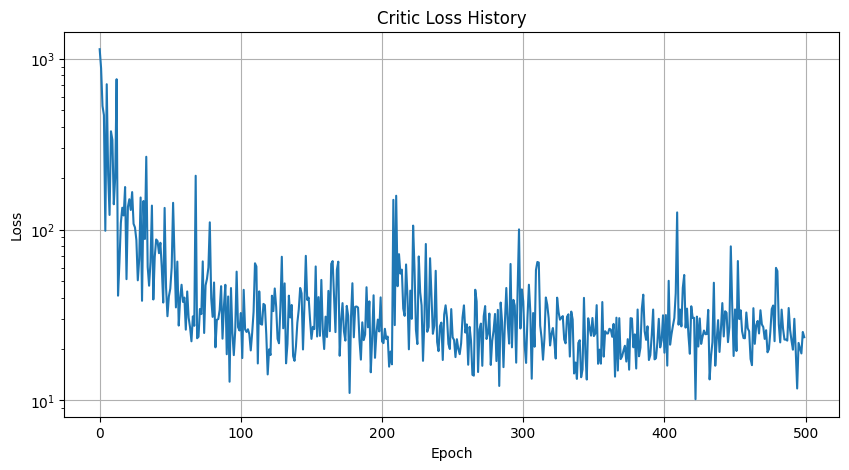

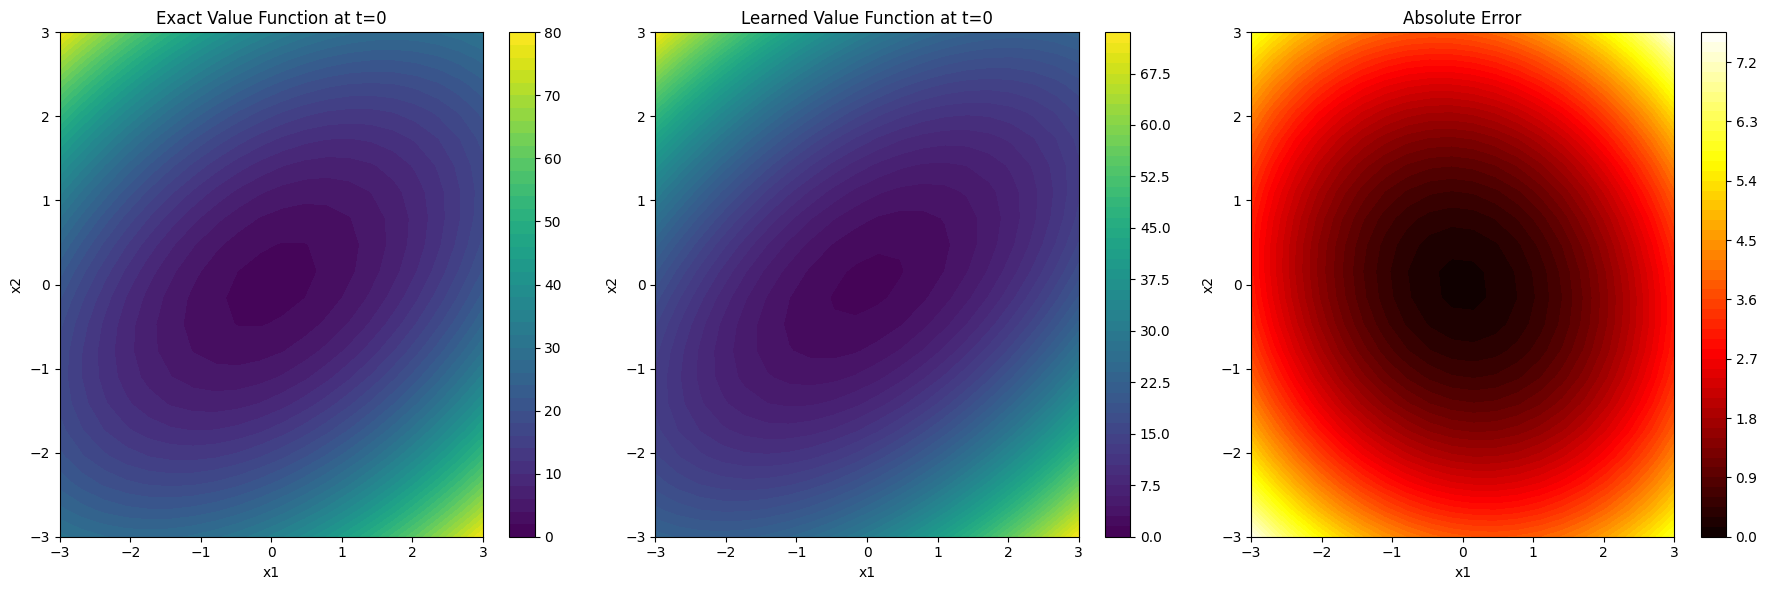

Final maximum error: 4.806911e+01


In [49]:
run_critic_algorithm()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

# Assume SoftLQR class is defined elsewhere and works correctly with float64
# from soft_lqr_solver import SoftLQR # Example import

class PolicyNN(nn.Module):
    """Neural network to approximate the optimal policy for soft LQR.
    Outputs the mean and covariance of the control distribution."""

    def __init__(self, d=2, hidden_size=256, device=torch.device("cpu")):
        super(PolicyNN, self).__init__()
        self.d = d  # State dimension
        self.device = device

        # Create neural network with 3 hidden layers, all explicitly using float64
        # Note: Original code used 3 hidden layers (time_embedding + 2 hidden)
        self.layer1 = nn.Linear(1, hidden_size, device=device, dtype=torch.float64)
        self.layer2 = nn.Linear(hidden_size, hidden_size, device=device, dtype=torch.float64)
        self.layer3 = nn.Linear(hidden_size, hidden_size, device=device, dtype=torch.float64)

        # Output layers for action distribution parameters
        # Output for phi(t) - mapping from state to control mean (m x d) -> (d x d) in this case
        self.phi_output = nn.Linear(hidden_size, d * d, device=device, dtype=torch.float64)

        # Output for elements of the L matrix for Sigma(t) - covariance matrix
        self.sigma_output_L = nn.Linear(hidden_size, d * (d + 1) // 2, device=device, dtype=torch.float64)

        # Precompute indices for building the lower triangular matrix
        self.tri_indices = torch.tril_indices(d, d).to(device)
        self.eps = 1e-6 # For numerical stability of Sigma

    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor

    def forward(self, t):
        """
        Forward pass to compute policy parameters phi(t) and Sigma(t).
        MODIFIED: Always returns 3D tensors [batch, d, d].
        """
        # Ensure t is properly shaped and dtype
        t = self._ensure_float64(t.view(-1, 1))
        batch_size = t.shape[0] # Get batch size early

        # Forward pass through the network
        x = torch.relu(self.layer1(t))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x)) # Changed sigmoid to relu for consistency

        # Compute phi - matrix mapping state to mean of control distribution
        phi_flat = self.phi_output(x)
        phi = phi_flat.view(batch_size, self.d, self.d) # Shape [batch_size, d, d]

        # Compute L for covariance matrix Sigma = LL^T (ensures positive semi-definiteness)
        L_flat = self.sigma_output_L(x)

        # Create batched lower triangular matrices
        L = torch.zeros(batch_size, self.d, self.d, device=self.device, dtype=torch.float64)

        # Fill in the lower triangular elements
        L[:, self.tri_indices[0], self.tri_indices[1]] = L_flat

        # Compute Sigma = LL^T + eps*I for numerical stability
        Sigma = torch.bmm(L, L.transpose(1, 2)) #+ self.eps * torch.eye(self.d, device=self.device, dtype=torch.float64).unsqueeze(0) # Shape [batch_size, d, d]

        # REMOVED SQUEEZE LOGIC
        # if batch_size == 1:
        #     phi = phi.squeeze(0)
        #     Sigma = Sigma.squeeze(0)

        return phi, Sigma # Always returns [batch_size, d, d] tensors

    def action_distribution(self, t, x):
        """
        Compute the parameters of the control distribution N(mean, Sigma).

        Args:
            t: Time tensor (scalar or batch_size)
            x: State tensor (d or batch_size x d)

        Returns:
            Tuple of (means, covariance) for the control distribution
        """
        # Ensure inputs are float64
        t = self._ensure_float64(t)
        x = self._ensure_float64(x)

        # Ensure t has batch dimension for forward pass
        if t.dim() == 0:
            t = t.unsqueeze(0) # [1]

        # Get policy parameters
        phi, Sigma = self.forward(t) # phi: [b, d, d], Sigma: [b, d, d]

        # Ensure x has batch dimension [batch_size, d]
        if x.dim() == 1:
            x = x.unsqueeze(0) # Make it [1, d]

        # Handle potential batch size mismatches (e.g., single t, multiple x)
        batch_size_t = phi.shape[0]
        batch_size_x = x.shape[0]

        if batch_size_t == 1 and batch_size_x > 1:
            phi = phi.expand(batch_size_x, -1, -1)
            Sigma = Sigma.expand(batch_size_x, -1, -1)
            batch_size = batch_size_x
        elif batch_size_x == 1 and batch_size_t > 1:
             x = x.expand(batch_size_t, -1)
             batch_size = batch_size_t
        elif batch_size_t == batch_size_x:
             batch_size = batch_size_t
        else:
             raise ValueError(f"Batch size mismatch: t leads to batch {batch_size_t}, x has batch {batch_size_x}")


        # Ensure x is 3D for batch matrix multiplication: [batch_size, d, 1]
        x_3d = x.unsqueeze(2)

        # Compute mean = phi(t) @ x
        means = torch.bmm(phi, x_3d).squeeze(2) # Shape [batch_size, d]

        return means, Sigma

    def sample_action(self, t, x):
        """
        Sample from the control distribution N(mean, Sigma).

        Args:
            t: Time tensor (scalar or batch_size)
            x: State tensor (d or batch_size x d)

        Returns:
            Sampled control actions (batch_size x d)
        """
        # Ensure inputs are float64
        t = self._ensure_float64(t)
        x = self._ensure_float64(x)

        means, covariances = self.action_distribution(t, x) # means: [b, d], cov: [b, d, d]
        batch_size = means.shape[0]

        # Create the distribution object(s)
        # Need to handle potential batching issues if means/covariances are single tensors
        if batch_size == 1 and means.dim() == 1: # Single sample case
             dist = torch.distributions.MultivariateNormal(means, covariance_matrix=covariances)
             actions = dist.sample()
        else: # Batch case
            try:
                # Use Cholesky for stability in batch
                L = torch.linalg.cholesky(covariances) # [b, d, d]
                # Generate standard normal samples
                z = torch.randn(batch_size, self.d, 1, device=self.device, dtype=torch.float64) # [b, d, 1]
                # Transform: mean + L @ z
                actions = means + torch.bmm(L, z).squeeze(-1) # [b, d]
            except torch.linalg.LinAlgError as e:
                 print(f"Cholesky failed: {e}. Falling back to sampling (less efficient).")
                 # Fallback for potential numerical issues (less efficient)
                 actions = torch.zeros_like(means)
                 for i in range(batch_size):
                     dist_i = torch.distributions.MultivariateNormal(means[i], covariance_matrix=covariances[i])
                     actions[i] = dist_i.sample()

        return actions


class ActorAlgorithm:
    """Implementation of the actor algorithm for soft LQR, which learns
    the optimal policy using the exact value function."""

    def __init__(self,
                 soft_lqr: SoftLQR, # Assume SoftLQR class is defined and works
                 hidden_size: int = 256,
                 learning_rate: float = 1e-4,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the actor algorithm.

        Args:
            soft_lqr: Instance of SoftLQR class with exact value function
            hidden_size: Size of hidden layers in the policy network
            learning_rate: Learning rate for optimization
            device: Device to use for computation
        """
        self.soft_lqr = soft_lqr
        self.device = device
        self.d = soft_lqr.d # State dimension

        # Create policy network and ensure it uses float64
        self.policy_network = PolicyNN(d=self.d, hidden_size=hidden_size, device=device)
        self.policy_network.to(dtype=torch.float64) # Ensure parameters are float64

        # Create optimizer
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)

        # --- For tracking progress ---
        self.loss_history = [] # Stores surrogate objective (KL divergence)
        self.gradient_norm_history = [] # Stores L2 norm of gradients
        self.eval_epochs = [] # Stores epochs where evaluation was performed
        self.mean_error_history = [] # Stores parameter error for phi(t)x
        self.cov_error_history = [] # Stores parameter error for Sigma
        self.policy_gradient_objective_history = []

    def _rollout_trajectory(self, x0: torch.Tensor, N_steps: int) -> List[Tuple[float, torch.Tensor, torch.Tensor, float, float, torch.Tensor]]:
        """
        Simulate one episode using the *current learned policy*.
        Internal method for monitoring the policy gradient objective.

        Args:
            x0: Initial state tensor (d)
            N_steps: Number of steps in the rollout

        Returns:
            List of tuples: (t_n, x_n, a_n, cost_n, log_prob_n, x_{n+1})
        """
        self.policy_network.eval() # Use eval mode for consistent sampling during rollout

        x0 = self._ensure_float64(x0).to(self.device)
        trajectory = []
        x_current = x0.clone()
        t_current = 0.0
        dt = self.soft_lqr.T / N_steps
        sqrt_dt = np.sqrt(dt)

        # Pre-generate noise for the episode
        dW_episode = torch.randn((N_steps, self.soft_lqr.sigma.shape[1]), device=self.device, dtype=torch.float64) * sqrt_dt

        # Get necessary matrices (ensure float64)
        H = self._ensure_float64(self.soft_lqr.H)
        M = self._ensure_float64(self.soft_lqr.M)
        C = self._ensure_float64(self.soft_lqr.C)
        D = self._ensure_float64(self.soft_lqr.D) # Use original D for cost
        sigma = self._ensure_float64(self.soft_lqr.sigma)

        with torch.no_grad(): # No gradients needed for rollout simulation
            for n in range(N_steps):
                t_tensor = torch.tensor(t_current, device=self.device, dtype=torch.float64)

                # 1. Get policy distribution and sample action
                # Need batch dim for network methods
                means, covariances = self.policy_network.action_distribution(t_tensor.unsqueeze(0), x_current.unsqueeze(0))
                dist = torch.distributions.MultivariateNormal(means.squeeze(0), covariance_matrix=covariances.squeeze(0))
                a_n = dist.sample() # Shape [d]

                # 2. Calculate log probability ln p^θ(a_n | t_n, x_n)
                log_prob_n = dist.log_prob(a_n) # Scalar

                # 3. Calculate instantaneous cost cost_n = x_n^T C x_n + a_n^T D a_n
                cost_state = torch.dot(x_current, C @ x_current)
                cost_control = torch.dot(a_n, D @ a_n) # Use original D
                cost_n = cost_state + cost_control

                # 4. Simulate next state using Euler-Maruyama
                drift = H @ x_current + M @ a_n
                diffusion = sigma @ dW_episode[n]
                x_next = x_current + drift * dt + diffusion

                # Store step data including x_next
                trajectory.append((t_current, x_current.clone(), a_n, cost_n.item(), log_prob_n.item(), x_next.clone()))

                # Update state and time
                x_current = x_next
                t_current += dt
                t_current = min(t_current, self.soft_lqr.T) # Cap at T

        return trajectory
   
    def _compute_pg_objective_from_rollout(self, trajectory: List[Tuple[float, torch.Tensor, torch.Tensor, float, float, torch.Tensor]]) -> float:
        """
        Compute the average (advantage * log_prob) for monitoring purposes.
        Uses the exact value function v* from self.soft_lqr.

        Args:
            trajectory: List of (t_n, x_n, a_n, cost_n, log_prob_n, x_{n+1}) tuples.

        Returns:
            The average policy gradient objective value for the episode (float).
        """
        N_steps = len(trajectory)
        if N_steps == 0:
            return 0.0

        dt = self.soft_lqr.T / N_steps
        total_objective = 0.0

        # Pre-calculate all needed v* values
        t_vals_v = torch.tensor([traj[0] for traj in trajectory] + [self.soft_lqr.T], device=self.device, dtype=torch.float64)
        x_vals_v = torch.stack([traj[1] for traj in trajectory] + [trajectory[-1][5]], dim=0) # x_0, ..., x_{N-1}, x_N

        # Ensure SoftLQR components are ready for value function calculation
        # self.soft_lqr.to(self.device, torch.float64) # Assumed helper
        v_star_values = self.soft_lqr.value_function(t_vals_v, x_vals_v).to(torch.float64) # [N+1] values

        with torch.no_grad(): # No gradients needed for this calculation
            for n in range(N_steps):
                t_n, x_n, a_n, cost_n, log_prob_n_float, x_next = trajectory[n]

                # Advantage calculation using v*
                v_star_n = v_star_values[n]
                v_star_n_plus_1 = v_star_values[n+1]
                advantage = torch.tensor(cost_n * dt, dtype=torch.float64, device=self.device) + v_star_n_plus_1 - v_star_n

                # Use the stored log_prob (float)
                log_prob_n = torch.tensor(log_prob_n_float, dtype=torch.float64, device=self.device)

                # Accumulate objective term
                objective_term_n = advantage * log_prob_n
                total_objective += objective_term_n.item() # Accumulate as float

        return total_objective / N_steps # Return average

    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor

    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a batch of random states and times for training.

        Args:
            batch_size: Number of samples to generate
            state_range: Range for uniform sampling of states

        Returns:
            Tuple of (times, states) tensors [batch_size], [batch_size, d]
        """
        # Sample times uniformly from [0, T]
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T

        # Sample states uniformly from [-state_range, state_range]^d
        states = (torch.rand(batch_size, self.d, device=self.device, dtype=torch.float64) * 2 - 1) * state_range

        return times, states

    def compute_kl_divergence_loss(self, t, x) -> torch.Tensor:
        """
        Compute the KL divergence KL( pi_learned || pi_optimal ) averaged over the batch.
        This serves as the surrogate objective function to minimize.

        Args:
            t: Time tensor (batch_size)
            x: State tensor (batch_size x d)

        Returns:
            Mean KL divergence (scalar tensor, requires grad).
        """
        batch_size = t.shape[0]

        # Ensure inputs are float64
        t = self._ensure_float64(t)
        x = self._ensure_float64(x)

        # Get action distributions from both policies
        # Learned: N(mu_learned, Sigma_learned)
        mu_learned, Sigma_learned = self.policy_network.action_distribution(t, x)

        # Optimal: N(mu_optimal, Sigma_optimal)
        # Ensure SoftLQR components are float64 and on the correct device
        # self.soft_lqr.to(self.device, torch.float64) # Helper method assumed in SoftLQR
        mu_optimal, Sigma_optimal = self.soft_lqr.optimal_control_distribution(t, x)

        # Ensure optimal_covariance is properly shaped for batch operations
        if Sigma_optimal.dim() < 3 and batch_size > 0:
            Sigma_optimal = Sigma_optimal.unsqueeze(0).expand(batch_size, -1, -1)
        elif Sigma_optimal.dim() == 2 and batch_size == 0: # Handle empty batch case
             return torch.tensor(0.0, device=self.device, dtype=torch.float64, requires_grad=True)


        # Compute precision matrix (inverse of optimal covariance)
        # Add small identity for stability before inverse
        eps_eye = torch.eye(self.d, device=self.device, dtype=torch.float64) * 1e-6
        Sigma_optimal_stable = Sigma_optimal + eps_eye
        try:
            optimal_precision = torch.inverse(Sigma_optimal_stable) # [b, d, d]
        except torch.linalg.LinAlgError:
             print("Warning: Optimal Sigma inverse failed. Using pseudo-inverse.")
             optimal_precision = torch.linalg.pinv(Sigma_optimal_stable)


        # Compute mean difference
        mean_diff = mu_optimal - mu_learned # [b, d]

        # Compute KL divergence terms (vectorized)
        # Term 1: tr(Sigma_optimal_inv @ Sigma_learned)
        # torch.bmm: [b, d, d] @ [b, d, d] -> [b, d, d]
        # torch.diagonal extracts diagonals for trace sum
        term1 = torch.diagonal(torch.bmm(optimal_precision, Sigma_learned), dim1=-2, dim2=-1).sum(dim=-1) # [b]

        # Term 2: (mu_optimal - mu_learned)^T @ Sigma_optimal_inv @ (mu_optimal - mu_learned)
        # mean_diff.unsqueeze(-1): [b, d, 1]
        # optimal_precision @ mean_diff.unsqueeze(-1): [b, d, 1]
        # mean_diff.unsqueeze(1): [b, 1, d]
        # torch.bmm(mean_diff.unsqueeze(1), ...): [b, 1, 1] -> squeeze -> [b]
        term2 = torch.bmm(mean_diff.unsqueeze(1), torch.bmm(optimal_precision, mean_diff.unsqueeze(-1))).squeeze() # [b]

        # Term 3: -d (dimensionality)
        term3 = -torch.tensor(self.d, device=self.device, dtype=torch.float64) # scalar

        # Term 4: log(det(Sigma_optimal) / det(Sigma_learned)) = logdet(Sigma_optimal) - logdet(Sigma_learned)
        # Add small identity for stability before logdet
        Sigma_learned_stable = Sigma_learned + eps_eye
        logdet_optimal = torch.logdet(Sigma_optimal_stable) # [b]
        logdet_learned = torch.logdet(Sigma_learned_stable) # [b]
        term4 = logdet_optimal - logdet_learned # [b]

        # Compute KL divergence: 0.5 * (term1 + term2 + term3 + term4)
        kl_div = 0.5 * (term1 + term2 + term3 + term4) # [b]

        # Return mean KL divergence over the batch
        return kl_div.mean() # scalar, requires_grad

    def train_step(self, batch_size: int) -> Tuple[float, float]:
        """
        Perform one training step of the actor algorithm.

        Args:
            batch_size: Batch size for training

        Returns:
            Tuple[float, float]: (Loss value from this step, Gradient norm)
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)

        # Compute KL divergence loss (surrogate objective)
        loss = self.compute_kl_divergence_loss(times, states)

        # Perform optimization step
        self.optimizer.zero_grad()
        # Check if loss requires grad (it should)
        if loss.requires_grad:
            loss.backward()

            # --- Calculate Gradient Norm ---
            total_norm = 0.0
            for p in self.policy_network.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            grad_norm = total_norm ** 0.5
            # ------------------------------

            # Optional: Gradient Clipping
            # torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)

            self.optimizer.step()
        else:
             # Handle cases where loss might not require grad (e.g., batch_size=0)
             grad_norm = 0.0
             print("Warning: Loss did not require grad. Skipping optimizer step.")


        return loss.item(), grad_norm

    def train(self, num_epochs: int, batch_size: int, eval_interval: int = 10, N_steps_rollout: int = 100) -> None: # Added N_steps_rollout
        """
        Train the actor network.

        Args:
            num_epochs: Number of training epochs
            batch_size: Batch size for KL divergence loss calculation
            eval_interval: Interval for evaluation and progress reporting
            N_steps_rollout: Number of steps for the monitoring rollout (can differ from N used elsewhere)
        """
        print(f"Starting actor training for {num_epochs} epochs...")
        start_time = time.time()

        # Initial evaluation before training
        self.policy_network.eval() # Eval mode for initial checks
        mean_error, cov_error = self.evaluate()
        # --- Calculate initial PG objective ---
        x0_eval = self._generate_batch(1, state_range=3.0)[1].squeeze(0) # Sample one initial state
        initial_traj = self._rollout_trajectory(x0_eval, N_steps_rollout)
        initial_pg_obj = self._compute_pg_objective_from_rollout(initial_traj)
        # --- Store initial values ---
        self.eval_epochs.append(0)
        self.mean_error_history.append(mean_error)
        self.cov_error_history.append(cov_error)
        self.policy_gradient_objective_history.append(initial_pg_obj) # Store initial PG obj
        print(f"Epoch 0/{num_epochs}, Initial Mean Err: {mean_error:.6e}, Initial Cov Err: {cov_error:.6e}, Initial PG Obj: {initial_pg_obj:.6e}")


        for epoch in range(num_epochs):
            self.policy_network.train() # Set network to training mode
            loss, grad_norm = self.train_step(batch_size)
            self.loss_history.append(loss)
            self.gradient_norm_history.append(grad_norm) # Store the norm

            if (epoch + 1) % eval_interval == 0 or epoch == num_epochs - 1:
                self.policy_network.eval() # Set network to evaluation mode for consistency
                mean_error, cov_error = self.evaluate()
                # --- Calculate PG objective for monitoring ---
                x0_eval = self._generate_batch(1, state_range=3.0)[1].squeeze(0) # Sample one initial state
                current_traj = self._rollout_trajectory(x0_eval, N_steps_rollout)
                current_pg_obj = self._compute_pg_objective_from_rollout(current_traj)
                # --- Store eval results ---
                self.eval_epochs.append(epoch + 1)
                self.mean_error_history.append(mean_error)
                self.cov_error_history.append(cov_error)
                self.policy_gradient_objective_history.append(current_pg_obj) # Store current PG obj
                # --- END Store ---
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1}/{num_epochs}, KL Loss: {loss:.6e}, Grad Norm: {grad_norm:.6e}, Mean Err: {mean_error:.6e}, Cov Err: {cov_error:.6e}, PG Obj: {current_pg_obj:.6e}, Time: {elapsed:.2f}s")

        print(f"Training completed in {time.time() - start_time:.2f} seconds.")


    def evaluate(self, grid_size: int = 5, state_range: float = 3.0, time_points: Optional[List[float]] = None) -> Tuple[float, float]:
        """
        Evaluate the actor network against the exact optimal policy.

        Args:
            grid_size: Number of points in each dimension for evaluation grid
            state_range: Range for evaluation grid [-range, range]
            time_points: Specific time points for evaluation, defaults to [0, T/3, 2T/3, T]

        Returns:
            Tuple of (average_mean_error, average_covariance_error) over the grid
        """
        self.policy_network.eval() # Ensure evaluation mode

        # Set default time points if not provided
        if time_points is None:
            time_points = [0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T]

        # Create evaluation grid for states
        x_coords = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        # Create all combinations of coordinates for d=2
        state_grid = torch.cartesian_prod(x_coords, x_coords) # Shape [grid_size*grid_size, d]

        # Convert time points to tensor
        time_tensor = torch.tensor(time_points, device=self.device, dtype=torch.float64)

        # Store errors
        total_mean_error = 0.0
        total_cov_error = 0.0
        count = 0

        # Evaluate on grid
        with torch.no_grad():
            for t in time_tensor:
                # Process all states for this time point in a batch
                t_batch = t.repeat(state_grid.shape[0]) # [grid_size*grid_size]

                # Compute optimal policy parameters for the batch
                optimal_means, optimal_cov = self.soft_lqr.optimal_control_distribution(t_batch, state_grid)
                # Ensure optimal_cov is batched correctly
                if optimal_cov.dim() < 3:
                     optimal_cov = optimal_cov.unsqueeze(0).expand(state_grid.shape[0], -1, -1)


                # Compute learned policy parameters for the batch
                learned_means, learned_cov = self.policy_network.action_distribution(t_batch, state_grid)

                # Compute errors using vectorized operations
                mean_error = torch.norm(optimal_means - learned_means, dim=1).mean().item() # Avg norm over batch
                cov_error = torch.norm(optimal_cov - learned_cov, dim=(1, 2)).mean().item() # Avg norm over batch

                # Accumulate errors (weighted by number of states evaluated at this time)
                total_mean_error += mean_error * state_grid.shape[0]
                total_cov_error += cov_error * state_grid.shape[0]
                count += state_grid.shape[0]

        # Return average errors over the entire grid (all times, all states)
        avg_mean_error = total_mean_error / count if count > 0 else 0.0
        avg_cov_error = total_cov_error / count if count > 0 else 0.0
        return avg_mean_error, avg_cov_error

    # --- Plotting Functions ---

    def plot_loss_history(self) -> None:
        """Plot the surrogate objective (KL divergence loss) history."""
        if not self.loss_history:
            print("No loss history to plot.")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        # Use symlog if loss can be negative, otherwise log or linear
        min_loss = min(self.loss_history) if self.loss_history else 0
        if min_loss < 0:
             plt.yscale('symlog')
        else:
             plt.yscale('log')
        plt.xlabel('Training Step (Epoch)')
        plt.ylabel('Surrogate Objective (KL Divergence)')
        plt.title('Actor Training: Surrogate Objective History')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_gradient_norm_history(self) -> None:
        """Plot the policy gradient norm history."""
        if not self.gradient_norm_history:
            print("No gradient norm history to plot.")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_norm_history)
        plt.yscale('log') # Norms are non-negative, log scale is often useful
        plt.xlabel('Training Step (Epoch)')
        plt.ylabel('Policy Gradient L2 Norm')
        plt.title('Actor Training: Gradient Norm History')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_parameter_error_history(self) -> None:
        """Plot the parameter error history recorded during evaluation."""
        if not self.eval_epochs:
            print("No parameter error history to plot (evaluation likely not run periodically).")
            return

        fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        # Plot Mean Error (Error in phi(t)x or equivalent mean)
        axes[0].plot(self.eval_epochs, self.mean_error_history, 'o-', label='Mean Error Norm')
        axes[0].set_ylabel('Avg ||μ_learned - μ*||')
        axes[0].set_title('Actor Training: Parameter Error History')
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_yscale('log')

        # Plot Covariance Error
        axes[1].plot(self.eval_epochs, self.cov_error_history, 's-', color='red', label='Covariance Error Norm')
        axes[1].set_xlabel('Training Step (Epoch)')
        axes[1].set_ylabel('Avg ||Σ_learned - Σ*||_F')
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_yscale('log')

        plt.tight_layout()
        plt.show()

    def compare_policies(self, test_states: List[List[float]], dt: float = 0.01) -> None:
        """
        Compare trajectories using the learned policy versus the optimal policy.
        Optimized implementation with reduced redundant calculations.

        Args:
            test_states: List of initial states to test
            dt: Time step for simulation
        """
        self.policy_network.eval() # Ensure eval mode for sampling

        # Convert test states to tensors
        num_states = len(test_states)
        test_states_tensor = torch.tensor(test_states, device=self.device, dtype=torch.float64)

        # Time points for simulation
        num_steps = int(self.soft_lqr.T / dt) + 1 # Ensure T is included
        time_points = torch.linspace(0, self.soft_lqr.T, num_steps, device=self.device, dtype=torch.float64)

        # Initialize plot
        fig, axes = plt.subplots(num_states, 2, figsize=(16, 4*num_states), squeeze=False) # Ensure axes is always 2D

        # Pre-compute matrices used in every iteration
        sqrt_dt = np.sqrt(dt)
        H = self.soft_lqr.H.to(dtype=torch.float64)
        M = self.soft_lqr.M.to(dtype=torch.float64)
        sigma = self.soft_lqr.sigma.to(dtype=torch.float64)
        C = self.soft_lqr.C.to(dtype=torch.float64)
        D = self.soft_lqr.D.to(dtype=torch.float64) # Use original D for cost
        R = self.soft_lqr.R.to(dtype=torch.float64)

        # Simulation loop for each initial state
        for i, x0_single in enumerate(test_states_tensor):
            x0 = x0_single.view(1, -1)  # Add batch dimension [1, d]

            # Initialize trajectories and costs
            learned_traj = torch.zeros((num_steps, self.d), device=self.device, dtype=torch.float64)
            optimal_traj = torch.zeros((num_steps, self.d), device=self.device, dtype=torch.float64)
            learned_traj[0] = x0_single
            optimal_traj[0] = x0_single

            learned_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            optimal_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)

            # Generate noise once for both simulations
            noise_seq = torch.randn((num_steps - 1, sigma.shape[1]), device=self.device, dtype=torch.float64) * sqrt_dt

            # Simulate trajectories step-by-step
            current_learned_x = x0_single
            current_optimal_x = x0_single
            cumulative_learned_cost = 0.0
            cumulative_optimal_cost = 0.0

            with torch.no_grad(): # No gradients needed for simulation/comparison
                for n in range(num_steps - 1):
                    t_n = time_points[n]
                    t_tensor = t_n.unsqueeze(0) # [1]

                    # Get controls from policies
                    learned_control = self.policy_network.sample_action(t_tensor, current_learned_x.unsqueeze(0)).squeeze(0) # [d]
                    optimal_control = self.soft_lqr.optimal_control(t_tensor, current_optimal_x.unsqueeze(0)).squeeze(0) # [d]

                    # Calculate costs for step n
                    learned_state_cost = torch.dot(current_learned_x, C @ current_learned_x)
                    learned_control_cost = torch.dot(learned_control, D @ learned_control)
                    cumulative_learned_cost += (learned_state_cost + learned_control_cost) * dt
                    learned_costs[n+1] = cumulative_learned_cost # Store cumulative cost up to end of step n

                    optimal_state_cost = torch.dot(current_optimal_x, C @ current_optimal_x)
                    optimal_control_cost = torch.dot(optimal_control, D @ optimal_control)
                    cumulative_optimal_cost += (optimal_state_cost + optimal_control_cost) * dt
                    optimal_costs[n+1] = cumulative_optimal_cost # Store cumulative cost up to end of step n

                    # Calculate drift terms
                    learned_drift = H @ current_learned_x + M @ learned_control
                    optimal_drift = H @ current_optimal_x + M @ optimal_control

                    # Apply common noise term
                    noise_term = sigma @ noise_seq[n]

                    # Update states for next iteration
                    current_learned_x = current_learned_x + learned_drift * dt + noise_term
                    current_optimal_x = current_optimal_x + optimal_drift * dt + noise_term

                    # Store next state
                    learned_traj[n+1] = current_learned_x
                    optimal_traj[n+1] = current_optimal_x

            # Add terminal costs
            learned_terminal = torch.dot(learned_traj[-1], R @ learned_traj[-1])
            optimal_terminal = torch.dot(optimal_traj[-1], R @ optimal_traj[-1])
            learned_costs[-1] += learned_terminal
            optimal_costs[-1] += optimal_terminal

            # --- Plotting ---
            ax1 = axes[i, 0]
            ax1.plot(learned_traj.cpu().numpy()[:, 0], learned_traj.cpu().numpy()[:, 1], 'b-', label='Learned Policy')
            ax1.plot(optimal_traj.cpu().numpy()[:, 0], optimal_traj.cpu().numpy()[:, 1], 'r-', label='Optimal Policy')
            ax1.scatter([x0_single[0].item()], [x0_single[1].item()], color='g', s=100, marker='o', label='Initial State')
            ax1.set_title(f'Trajectories from {x0_single.cpu().numpy()}')
            ax1.set_xlabel('X1')
            ax1.set_ylabel('X2')
            ax1.grid(True)
            ax1.legend()

            ax2 = axes[i, 1]
            ax2.plot(time_points.cpu().numpy(), learned_costs.cpu().numpy(), 'b-', label='Learned Policy Cost')
            ax2.plot(time_points.cpu().numpy(), optimal_costs.cpu().numpy(), 'r-', label='Optimal Policy Cost')
            ax2.set_title(f'Cumulative Cost from {x0_single.cpu().numpy()}')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Cost')
            ax2.grid(True)
            ax2.legend()

            print(f"Initial state {x0_single.cpu().numpy()}:")
            print(f"  Learned policy final cost: {learned_costs[-1].item():.4f}")
            print(f"  Optimal policy final cost: {optimal_costs[-1].item():.4f}")
            print(f"  Cost difference: {(learned_costs[-1] - optimal_costs[-1]).item():.4f}")

        plt.tight_layout()
        plt.show()

    def plot_policy_gradient_loss_history(self) -> None:
        """Plot the monitored policy gradient objective history."""
        if not self.eval_epochs or not self.policy_gradient_objective_history:
            print("No policy gradient objective history to plot (rollouts likely not run periodically).")
            return
        # Ensure lengths match if initial value was added
        epochs_to_plot = self.eval_epochs
        pg_obj_to_plot = self.policy_gradient_objective_history
        if len(epochs_to_plot) != len(pg_obj_to_plot):
            print(f"Warning: Mismatch in lengths of eval_epochs ({len(epochs_to_plot)}) and pg_objective_history ({len(pg_obj_to_plot)}). Plotting available data.")
            min_len = min(len(epochs_to_plot), len(pg_obj_to_plot))
            epochs_to_plot = epochs_to_plot[:min_len]
            pg_obj_to_plot = pg_obj_to_plot[:min_len]


        plt.figure(figsize=(10, 5))
        plt.plot(epochs_to_plot, pg_obj_to_plot, 'o-')
        plt.yscale('symlog') # This objective can be positive or negative
        plt.xlabel('Training Step (Epoch)')
        plt.ylabel('Avg(Advantage * log_prob)')
        plt.title('Actor Training: Monitored Policy Gradient Objective')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# --- Main Execution ---
def run_actor_algorithm():
    """Run the actor algorithm for soft LQR."""
    # Setup device
    if torch.cuda.is_available():
         device = torch.device("cuda")
         print("Using CUDA device")
    else:
         device = torch.device("cpu")
         print("Using CPU device")

    # Set the problem matrices as specified in assignment (Figure 1)
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1 # Original D
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0

    # Set parameters (e.g., from Exercise 2.1 or hints if different)
    T = 0.5
    tau = 0.1   # Example value
    gamma = 10.0 # Example value

    # Create time grid for Riccati solver
    grid_size = 1001 # Finer grid for accuracy
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64, device=device)

    # Create soft LQR instance and solve Ricatti ODE for exact v* and pi*
    print("Solving SoftLQR Riccati equation...")
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    print("SoftLQR solved.")

    # Create actor algorithm instance
    actor = ActorAlgorithm(soft_lqr,
                           hidden_size=256,
                           learning_rate=1e-3, # May need tuning
                           device=device)

    # Train actor
    actor.train(num_epochs=500, 
                batch_size=256,
                eval_interval=25, 
                N_steps_rollout=100) 

    # --- Plot results ---
    actor.plot_loss_history()
    actor.plot_gradient_norm_history()
    actor.plot_parameter_error_history()
    actor.plot_policy_gradient_loss_history()

    # Compare policies on test states
    test_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    actor.compare_policies(test_states)

    # Evaluate final performance
    mean_error, cov_error = actor.evaluate(grid_size=10) # Evaluate on a denser grid
    print(f"\nFinal Average Mean Error (over grid): {mean_error:.6e}")
    print(f"Final Average Covariance Error (over grid): {cov_error:.6e}")

    return actor

Using CPU device
Solving SoftLQR Riccati equation...
SoftLQR solved.
Starting actor training for 500 epochs...
Epoch 0/500, Initial Mean Err: 1.014380e+02, Initial Cov Err: 1.420001e+00, Initial PG Obj: 2.729473e+00
Epoch 25/500, KL Loss: 8.571910e+02, Grad Norm: 2.304473e+02, Mean Err: 9.309487e+01, Cov Err: 1.098852e+00, PG Obj: -1.858703e-02, Time: 1.73s
Epoch 50/500, KL Loss: 1.609352e+02, Grad Norm: 1.336506e+02, Mean Err: 8.920074e+01, Cov Err: 6.078399e-01, PG Obj: -1.003169e-02, Time: 3.06s
Epoch 75/500, KL Loss: 2.558977e+02, Grad Norm: 1.400801e+02, Mean Err: 8.566602e+01, Cov Err: 9.205109e-01, PG Obj: 3.582053e-03, Time: 4.47s
Epoch 100/500, KL Loss: 3.447268e+02, Grad Norm: 1.863418e+02, Mean Err: 8.283914e+01, Cov Err: 1.441057e+00, PG Obj: 5.529367e-03, Time: 6.00s
Epoch 125/500, KL Loss: 2.475666e+02, Grad Norm: 1.004213e+02, Mean Err: 7.961640e+01, Cov Err: 5.158007e-01, PG Obj: -2.624861e-03, Time: 7.16s
Epoch 150/500, KL Loss: 4.117991e+02, Grad Norm: 3.758671e+02, M

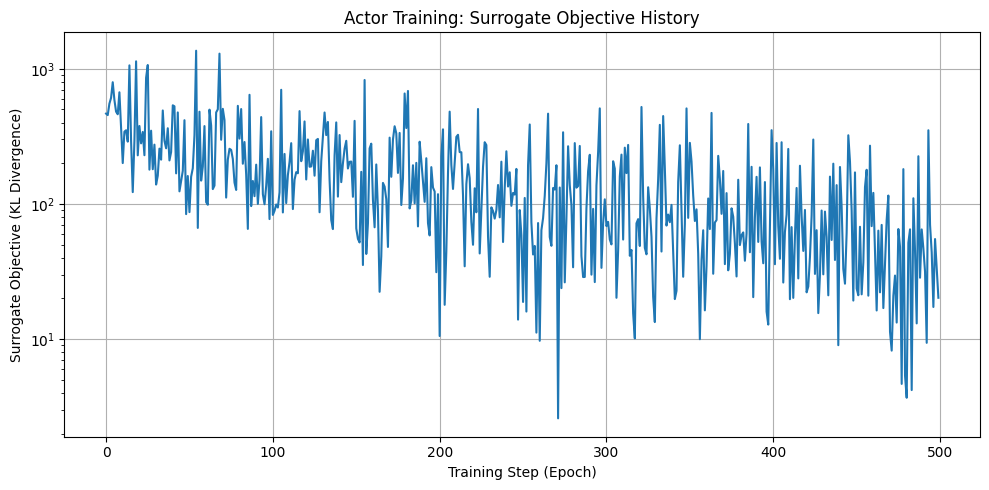

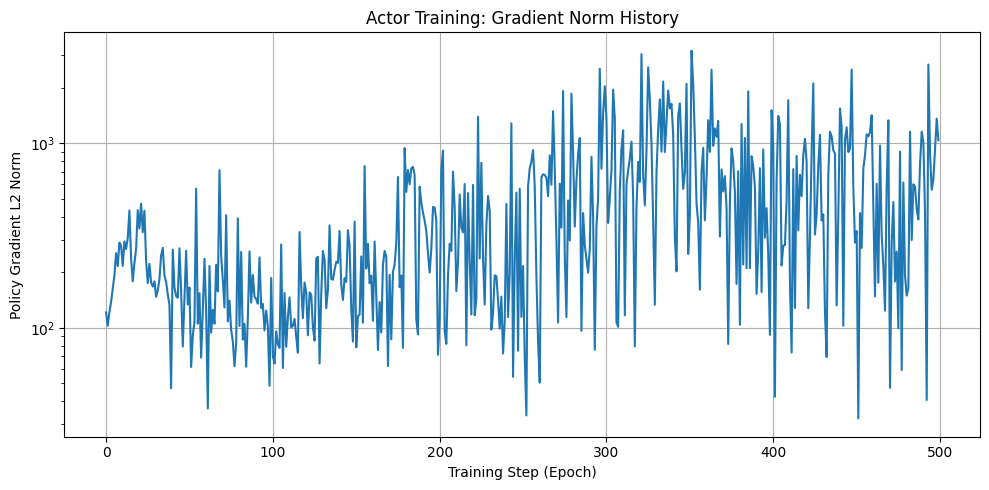

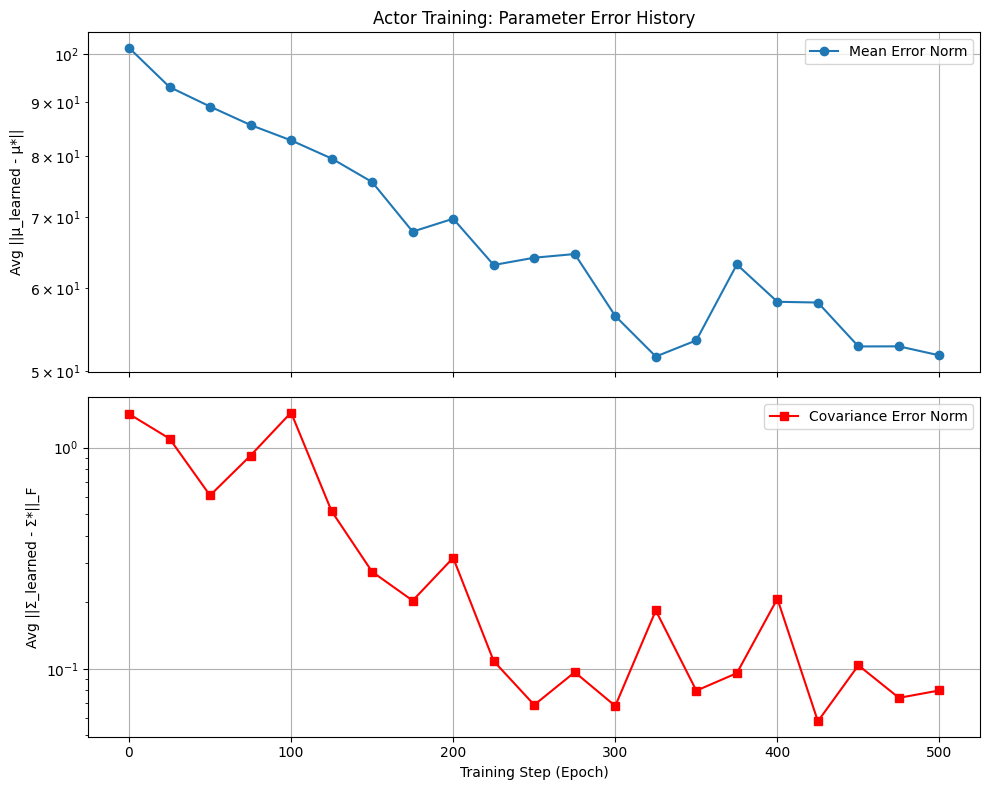

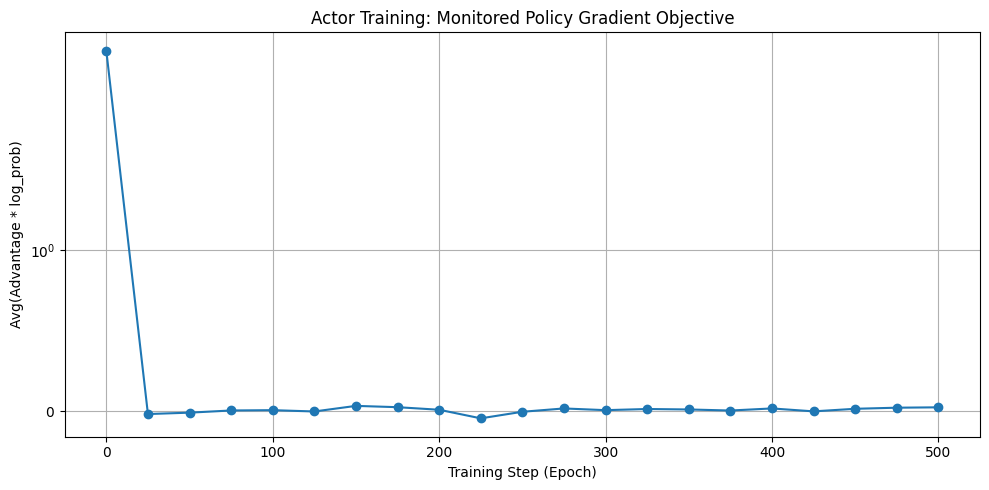

Initial state [2. 2.]:
  Learned policy final cost: 1.9803
  Optimal policy final cost: 1.9645
  Cost difference: 0.0158
Initial state [ 2. -2.]:
  Learned policy final cost: 6.0907
  Optimal policy final cost: 6.0925
  Cost difference: -0.0018
Initial state [-2. -2.]:
  Learned policy final cost: 2.6160
  Optimal policy final cost: 2.6013
  Cost difference: 0.0147
Initial state [-2.  2.]:
  Learned policy final cost: 5.8135
  Optimal policy final cost: 5.7676
  Cost difference: 0.0459


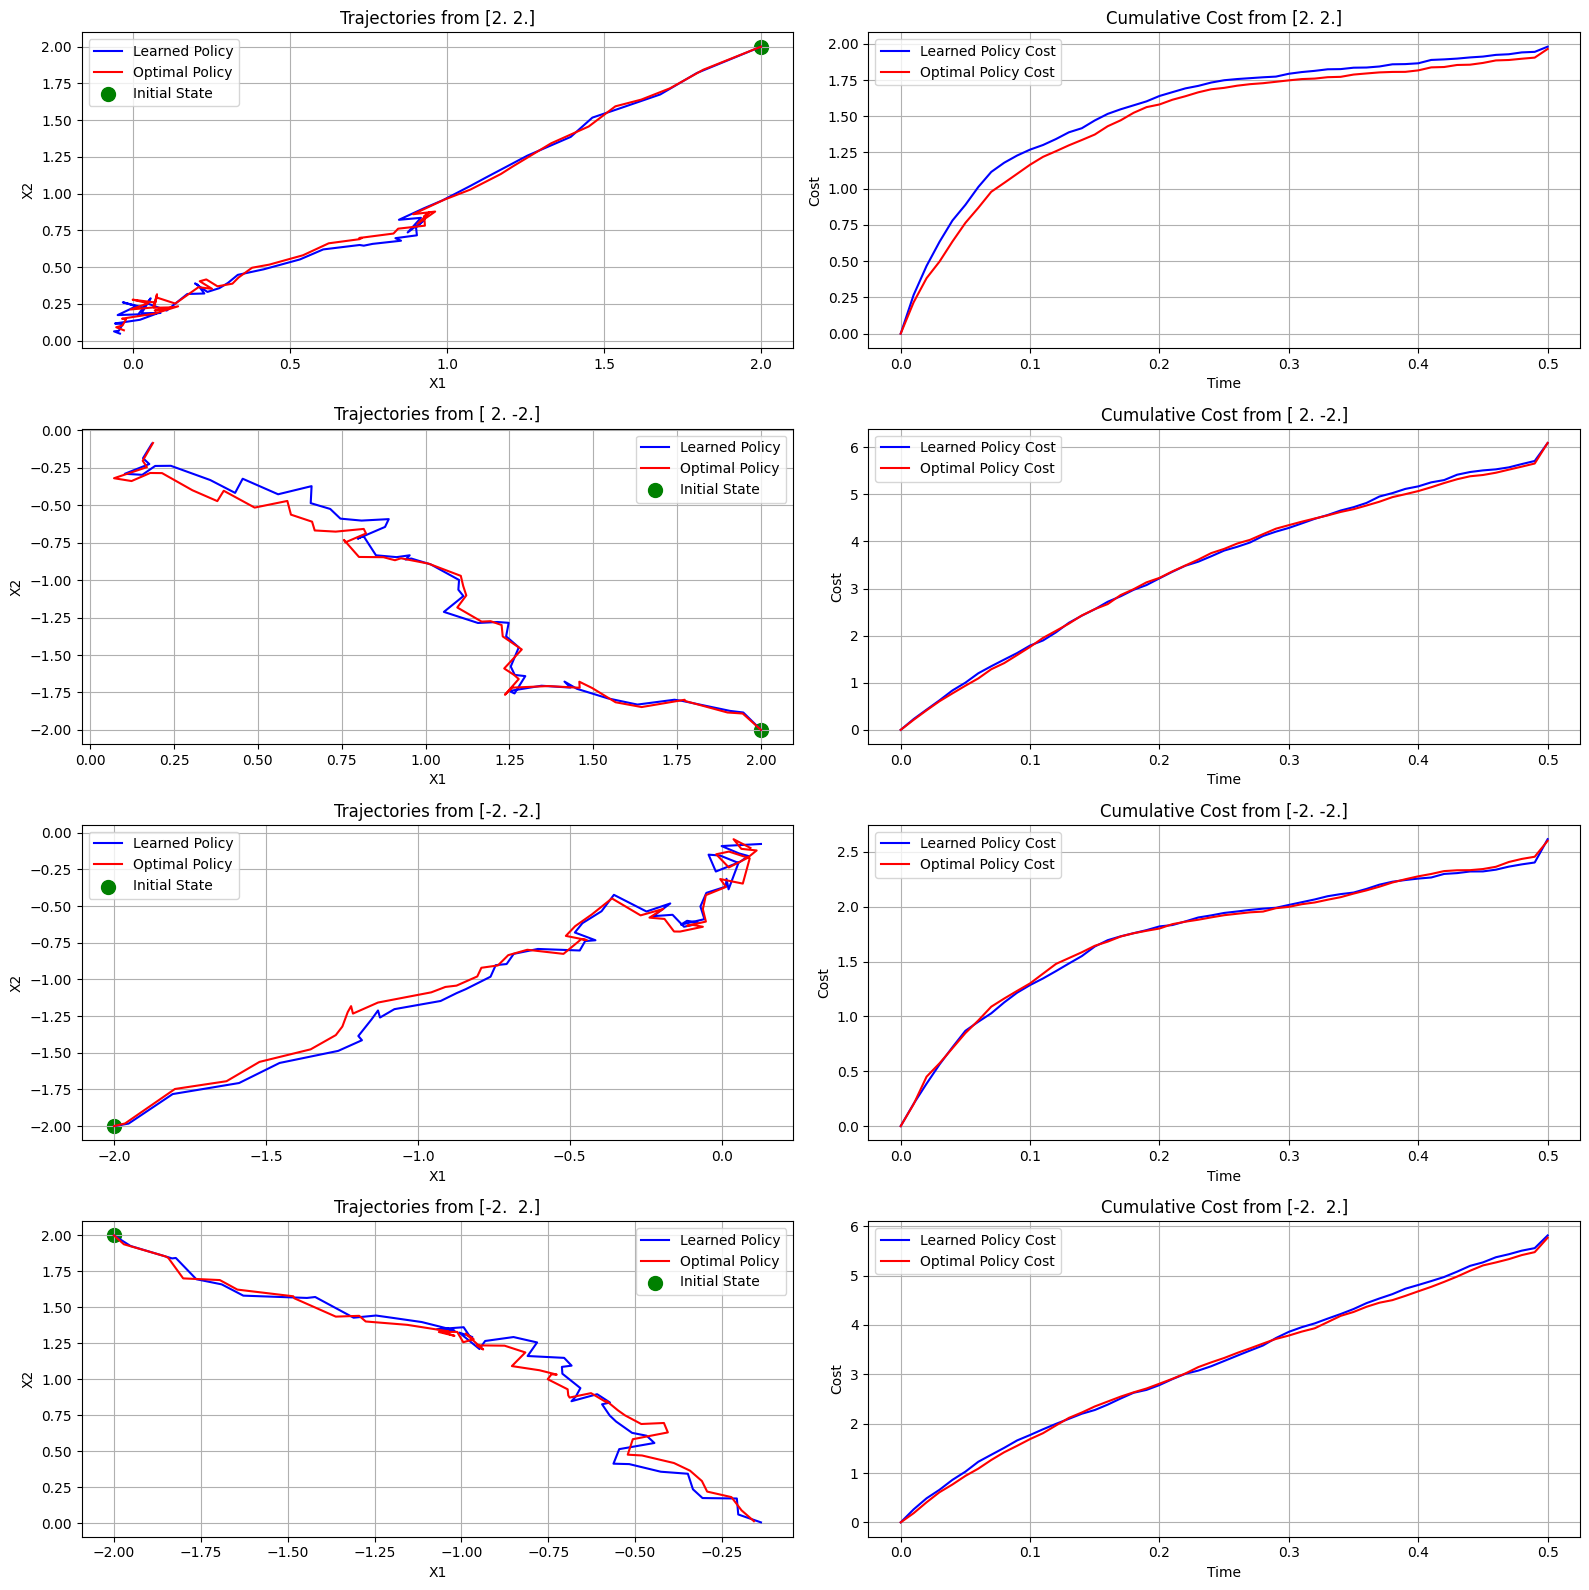


Final Average Mean Error (over grid): 4.676135e+01
Final Average Covariance Error (over grid): 7.973657e-02


In [51]:
trained_actor_algo = run_actor_algorithm()

## Question 5

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

class ActorCriticAlgorithm:
    """Implementation of the actor-critic algorithm for soft LQR."""
    
    def __init__(self, 
                 soft_lqr: SoftLQR, 
                 actor_hidden_size: int = 256, 
                 critic_hidden_size: int = 512,
                 actor_lr: float = 1e-4,
                 critic_lr: float = 1e-3,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the actor-critic algorithm.
        
        Args:
            soft_lqr: Instance of SoftLQR class
            actor_hidden_size: Size of hidden layers in the actor network
            critic_hidden_size: Size of hidden layers in the critic network
            actor_lr: Learning rate for actor optimization
            critic_lr: Learning rate for critic optimization
            device: Device to use for computation
        """
        self.soft_lqr = soft_lqr
        self.device = device
        
        # Create actor network (policy)
        self.policy_network = PolicyNN(d=soft_lqr.d, hidden_size=actor_hidden_size, device=device).to(device)
        
        # Create critic network (value function)
        self.value_network = ValueNN(hidden_size=critic_hidden_size, device=device).to(device)
        
        # Ensure all parameters are float64
        for param in self.policy_network.parameters():
            param.data = param.data.to(torch.float64)
        
        for param in self.value_network.parameters():
            param.data = param.data.to(torch.float64)
        
        # Create optimizers
        self.actor_optimizer = optim.Adam(self.policy_network.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.value_network.parameters(), lr=critic_lr)
        
        # MSE loss for critic
        self.critic_criterion = nn.MSELoss()
        
        # For tracking progress
        self.actor_loss_history = []
        self.critic_loss_history = []

    def _initialize_networks(self):
        """Initialize networks to better approximate optimal solution."""
        # Sample some states and times
        num_samples = 1000
        times = torch.rand(num_samples, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        states = (torch.rand(num_samples, self.soft_lqr.d, device=self.device, dtype=torch.float64) * 2 - 1) * 3.0
        
        # Get optimal values and policies
        with torch.no_grad():
            # For critic initialization
            optimal_values = torch.zeros(num_samples, device=self.device, dtype=torch.float64)
            for i in range(num_samples):
                t_i = times[i:i+1]
                x_i = states[i:i+1]
                optimal_values[i] = self.soft_lqr.value_function(t_i, x_i)
            
            # For actor initialization
            optimal_means = torch.zeros((num_samples, self.soft_lqr.m), device=self.device, dtype=torch.float64)
            for i in range(num_samples):
                t_i = times[i:i+1]
                x_i = states[i:i+1]
                means, _ = self.soft_lqr.optimal_control_distribution(t_i, x_i)
                optimal_means[i] = means.squeeze()
        
        # Pre-train critic to approximate optimal value function
        optimizer = optim.Adam(self.value_network.parameters(), lr=1e-3)
        for _ in range(100):  # Few steps of pre-training
            predicted_values = self.value_network.value_function(times, states)
            loss = nn.MSELoss()(predicted_values, optimal_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Pre-train actor to approximate optimal policy mean
        optimizer = optim.Adam(self.policy_network.parameters(), lr=1e-3)
        for _ in range(100):  # Few steps of pre-training
            means, _ = self.policy_network.action_distribution(times, states)
            loss = nn.MSELoss()(means, optimal_means)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor
    
    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a batch of random states and times for training.
        
        Args:
            batch_size: Number of samples to generate
            state_range: Range for uniform sampling of states
            
        Returns:
            Tuple of (times, states) tensors
        """
        # Sample times uniformly from [0, T]
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        
        # Sample states uniformly from [-state_range, state_range]^2
        states = (torch.rand(batch_size, self.soft_lqr.d, device=self.device, dtype=torch.float64) * 2 - 1) * state_range
        
        return times, states
    
    def _compute_target_values(self, t: torch.Tensor, x: torch.Tensor, num_steps: int = 100) -> torch.Tensor:
        """
        Compute target values for critic training by simulating trajectories using the current policy.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            num_steps: Number of time steps for simulation
            
        Returns:
            Target values tensor (batch)
        """
        batch_size = t.shape[0]
        target_values = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        for i in range(batch_size):
            # Current time and state
            t_i = t[i].item()
            x_i = x[i:i+1]
            
            # If we're already at terminal time, return terminal cost
            if t_i >= self.soft_lqr.T - 1e-6:
                target_values[i] = torch.matmul(torch.matmul(x_i.squeeze(), self.soft_lqr.R), x_i.squeeze())
                continue
            
            # Determine remaining time and step size
            remaining_time = self.soft_lqr.T - t_i
            dt = remaining_time / num_steps
            
            # Initialize state and cost
            current_state = x_i.clone()
            cost = 0.0
            
            # Simulate trajectory using current policy
            for step in range(num_steps):
                # Current time
                current_time = t_i + step * dt
                current_time_tensor = torch.tensor([current_time], device=self.device, dtype=torch.float64)
                
                # Get control action from current policy
                action = self.policy_network.sample_action(current_time_tensor, current_state)
                
                # Compute running cost
                state_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.C), current_state.squeeze())
                control_cost = torch.matmul(torch.matmul(action.squeeze(), self.soft_lqr.D), action.squeeze())
                
                # Add entropy regularization term
                _, covariance = self.policy_network.action_distribution(current_time_tensor, current_state)
                covariance = covariance[0] if covariance.dim() > 2 else covariance
                entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * np.pi * np.e * covariance)) / 2
                
                # Accumulate cost
                cost += (state_cost + control_cost + entropy_term) * dt
                
                # Update state with Euler step
                drift = self.soft_lqr.H @ current_state.squeeze() + self.soft_lqr.M @ action.squeeze()
                noise = self.soft_lqr.sigma @ torch.randn(self.soft_lqr.sigma.shape[1], device=self.device, dtype=torch.float64) * np.sqrt(dt)
                current_state = current_state + (drift * dt + noise).unsqueeze(0)
            
            # Add terminal cost
            terminal_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.R), current_state.squeeze())
            cost += terminal_cost
            
            target_values[i] = cost
        
        return target_values
    
    def train_critic_step(self, batch_size: int) -> float:
        """
        Perform one training step of the critic algorithm.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Loss value from this step
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute target values
        with torch.no_grad():
            target_values = self._compute_target_values(times, states)
        
        # Compute predicted values
        predicted_values = self.value_network.value_function(times, states)
        
        # Ensure consistent dtype before computing loss
        predicted_values = self._ensure_float64(predicted_values)
        target_values = self._ensure_float64(target_values)
        
        # Compute loss
        loss = self.critic_criterion(predicted_values, target_values)
        
        # Perform optimization step
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        
        return loss.item()
    
    def compute_td_values(self, t: torch.Tensor, x: torch.Tensor, dt: float = 0.01) -> torch.Tensor:
        """Compute temporal difference values with improved numerical stability."""
        batch_size = t.shape[0]
        td_values = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        for i in range(batch_size):
            t_i = t[i].item()
            
            # If at terminal time, use terminal cost
            if t_i >= self.soft_lqr.T - 1e-6:
                continue
            
            # Ensure we don't go beyond terminal time
            next_t = min(t_i + dt, self.soft_lqr.T)
            next_t_tensor = torch.tensor([next_t], device=self.device, dtype=torch.float64)
            
            # Current state
            x_i = x[i:i+1]
            current_t_tensor = torch.tensor([t_i], device=self.device, dtype=torch.float64)
            
            # Sample action from current policy with clipping
            action = self.policy_network.sample_action(current_t_tensor, x_i)
            action = torch.clamp(action, -10.0, 10.0)  # Add explicit clipping here too
            
            # Compute immediate cost
            state_cost = torch.matmul(torch.matmul(x_i.squeeze(), self.soft_lqr.C), x_i.squeeze())
            control_cost = torch.matmul(torch.matmul(action.squeeze(), self.soft_lqr.D), action.squeeze())
            
            # Add entropy regularization
            _, covariance = self.policy_network.action_distribution(current_t_tensor, x_i)
            covariance = covariance[0] if covariance.dim() > 2 else covariance
            # Add small regularization term to ensure stable determinant
            covariance = covariance + 1e-6 * torch.eye(covariance.shape[0], device=self.device, dtype=torch.float64)
            entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * np.pi * np.e * covariance)) / 2
            
            # Calculate immediate cost
            immediate_cost = (state_cost + control_cost + entropy_term) * dt
            
            # More stable next state computation using smaller substeps
            sub_steps = 5  # Use multiple smaller steps for integration
            sub_dt = dt / sub_steps
            next_state = x_i.clone()
            
            for _ in range(sub_steps):
                drift = self.soft_lqr.H @ next_state.squeeze() + self.soft_lqr.M @ action.squeeze()
                noise = self.soft_lqr.sigma @ torch.randn(self.soft_lqr.sigma.shape[1], 
                                                        device=self.device, 
                                                        dtype=torch.float64) * np.sqrt(sub_dt)
                next_state = next_state + (drift * sub_dt + noise).unsqueeze(0)
                
                # Add state clipping to prevent extreme values
                next_state = torch.clamp(next_state, -100.0, 100.0)
            
            # Compute value of next state
            with torch.no_grad():
                next_value = self.value_network.value_function(next_t_tensor, next_state)
                # Clamp next_value to reasonable range to prevent explosion
                next_value = torch.clamp(next_value, -1e6, 1e6)
            
            # Compute TD value: c + V(s')
            td_values[i] = immediate_cost + next_value
        
        return td_values
    
    def train_actor_step(self, batch_size: int) -> float:
        """
        Perform one training step of the actor algorithm using policy gradient.
        Vectorized implementation to compute policy gradient for all samples simultaneously.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Loss value from this step
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute TD values (expected costs)
        td_values = self.compute_td_values(times, states)
        
        # Create mask for non-terminal states
        non_terminal_mask = times < (self.soft_lqr.T - 1e-6)
        
        # Skip computation if all states are terminal
        if not non_terminal_mask.any():
            return 0.0
        
        # Get action distributions for all states in batch
        means, covariances = self.policy_network.action_distribution(times, states)
        
        # Handle different covariance shapes
        if covariances.dim() > 2:
            if covariances.dim() == 3:
                # Shape [batch, m, m]
                pass
            else:
                # Extra dimension, squeeze
                covariances = covariances.squeeze(1)
        
        # Sample actions for all states
        actions = self.policy_network.sample_action(times, states)
        
        # Compute log probabilities for all actions vectorized
        # Preparation for batch matrix multiplication
        mean_diff = actions - means  # [batch, m]
        
        # Add small regularization to covariances for numerical stability
        covariances_reg = covariances + 1e-6 * torch.eye(
            covariances.shape[-1], 
            device=self.device, 
            dtype=torch.float64
        ).unsqueeze(0).expand(batch_size, -1, -1)
        
        # Compute precision matrices (inverse of covariances)
        precisions = torch.inverse(covariances_reg)  # [batch, m, m]
        
        # Compute log determinants
        log_dets = torch.logdet(covariances_reg)  # [batch]
        
        # Compute quadratic term (x-μ)ᵀΣ⁻¹(x-μ) for all batch elements
        quad_terms = torch.bmm(
            torch.bmm(mean_diff.unsqueeze(1), precisions),  # [batch, 1, m]
            mean_diff.unsqueeze(2)  # [batch, m, 1]
        ).squeeze()  # [batch]
        
        # Compute log probabilities
        log_probs = -0.5 * (quad_terms + log_dets + self.soft_lqr.m * torch.log(torch.tensor(2 * np.pi, device=self.device, dtype=torch.float64)))
        
        # Compute advantages (negate TD values as we want to minimize cost)
        advantages = -td_values  # [batch]
        
        # Mask for non-terminal states
        masked_log_probs = log_probs[non_terminal_mask]
        masked_advantages = advantages[non_terminal_mask]
        
        # Compute policy loss using vectorized operations
        # We negate because optimizer minimizes
        policy_loss = -torch.mean(masked_log_probs * masked_advantages)
        
        # Zero gradients
        self.actor_optimizer.zero_grad()
        
        # Backward pass
        policy_loss.backward()
        
        # Update parameters
        self.actor_optimizer.step()
        
        return policy_loss.item()
    
    def train_step(self, batch_size: int) -> Tuple[float, float]:
        """
        Perform one combined actor-critic training step.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Tuple of (critic_loss, actor_loss)
        """
        # First update critic (value function)
        critic_loss = self.train_critic_step(batch_size)
        
        # Then update actor (policy)
        actor_loss = self.train_actor_step(batch_size)
        
        return critic_loss, actor_loss
    
    def train(self, num_epochs: int, batch_size: int, eval_interval: int = 10) -> None:
        """
        Train with improved stability measures.
        """
        print("Initializing networks to approximate optimal solution...")
        self._initialize_networks()
        
        print("Starting actor-critic training...")
        start_time = time.time()
        
        # Learning rate schedules
        actor_lr_start = 1e-4
        critic_lr_start = 1e-3
        
        for epoch in range(num_epochs):
            # Update learning rates with decay
            actor_lr = actor_lr_start * (0.99 ** (epoch // 10))
            critic_lr = critic_lr_start * (0.99 ** (epoch // 10))
            
            for param_group in self.actor_optimizer.param_groups:
                param_group['lr'] = actor_lr
            for param_group in self.critic_optimizer.param_groups:
                param_group['lr'] = critic_lr
            
            # Update critic multiple times per actor update
            critic_updates = 5
            avg_critic_loss = 0
            
            for _ in range(critic_updates):
                critic_loss = self.train_critic_step(batch_size)
                avg_critic_loss += critic_loss / critic_updates
            
            # Update actor
            actor_loss = self.train_actor_step(batch_size)
            
            self.critic_loss_history.append(avg_critic_loss)
            self.actor_loss_history.append(actor_loss)
            
            if (epoch + 1) % eval_interval == 0 or epoch == 0:
                # Evaluate and print progress
                value_error = self.evaluate_value_function()
                policy_error = self.evaluate_policy()
                elapsed = time.time() - start_time
                
                print(f"Epoch {epoch+1}/{num_epochs}, Critic Loss: {avg_critic_loss:.6e}, Actor Loss: {actor_loss:.6e}")
                print(f"Value Error: {value_error:.6e}, Policy Error: {policy_error:.6e}, Time: {elapsed:.2f}s")
                print(f"Actor LR: {actor_lr:.6e}, Critic LR: {critic_lr:.6e}")
                
                # Early stopping if we've achieved good results
                if value_error < 1e-2 and policy_error < 1e-2:
                    print("Reached convergence threshold, stopping training.")
                    break
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    
    def evaluate_value_function(self, grid_size: int = 5, state_range: float = 3.0) -> float:
        """
        Evaluate the critic network against the exact value function.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            
        Returns:
            Maximum absolute error
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Time points for evaluation
        time_points = torch.tensor([0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T], device=self.device, dtype=torch.float64)
        
        # Store total error
        total_error = 0.0
        count = 0
        
        # Evaluate on grid
        with torch.no_grad():
            for t in time_points:
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute exact and approximate value functions
                        exact_value = self.soft_lqr.value_function(t_batch, x)
                        approx_value = self.value_network.value_function(t_batch, x)
                        
                        # Ensure both are float64
                        exact_value = self._ensure_float64(exact_value)
                        approx_value = self._ensure_float64(approx_value)
                        
                        # Compute error
                        error = torch.abs(exact_value - approx_value).item()
                        total_error += error
                        count += 1
        
        # Return average error
        return total_error / count if count > 0 else 0.0
    
    def evaluate_policy(self, grid_size: int = 5, state_range: float = 3.0) -> float:
        """
        Evaluate the actor network against the exact optimal policy.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            
        Returns:
            Average error in policy means
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Time points for evaluation
        time_points = torch.tensor([0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T], device=self.device, dtype=torch.float64)
        
        # Store total error
        total_error = 0.0
        count = 0
        
        # Evaluate on grid
        with torch.no_grad():
            for t in time_points:
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute optimal and learned policy means
                        optimal_means, _ = self.soft_lqr.optimal_control_distribution(t_batch, x)
                        learned_means, _ = self.policy_network.action_distribution(t_batch, x)
                        
                        # Ensure both are float64
                        optimal_means = self._ensure_float64(optimal_means)
                        learned_means = self._ensure_float64(learned_means)
                        
                        # Compute error in means
                        error = torch.norm(optimal_means - learned_means).item()
                        total_error += error
                        count += 1
        
        # Return average error
        return total_error / count if count > 0 else 0.0
    
    def plot_loss_history(self) -> None:
        """Plot the loss history for both actor and critic during training."""
        plt.figure(figsize=(12, 5))
        
        # Plot critic loss
        plt.subplot(1, 2, 1)
        plt.plot(self.critic_loss_history)
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Critic Loss')
        plt.title('Critic Training Loss History')
        plt.grid(True)
        
        # Plot actor loss
        plt.subplot(1, 2, 2)
        plt.plot(self.actor_loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Actor Loss')
        plt.title('Actor Training Loss History')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_value_function_comparison(self, grid_size: int = 20, state_range: float = 3.0) -> None:
        """
        Plot comparison between exact and learned value function.
        
        Args:
            grid_size: Number of points in each dimension for plotting
            state_range: Range for plotting grid
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Evaluation time (t=0)
        t = torch.tensor([0.0], device=self.device, dtype=torch.float64)
        
        # Initialize arrays for values
        X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy())
        exact_values = np.zeros((grid_size, grid_size))
        approx_values = np.zeros((grid_size, grid_size))
        errors = np.zeros((grid_size, grid_size))
        
        # Compute values on grid
        with torch.no_grad():
            for i in range(grid_size):
                for j in range(grid_size):
                    # Current state
                    x = torch.tensor([[x_grid[i].item(), y_grid[j].item()]], device=self.device, dtype=torch.float64)
                    
                    # Compute exact and approximate value functions
                    exact_value = self.soft_lqr.value_function(t, x).item()
                    approx_value = self.value_network.value_function(t, x).item()
                    
                    # Store values
                    exact_values[j, i] = exact_value
                    approx_values[j, i] = approx_value
                    errors[j, i] = np.abs(exact_value - approx_value)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot exact value function
        im1 = axes[0].contourf(X, Y, exact_values, 50, cmap='viridis')
        axes[0].set_title('Exact Value Function at t=0')
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot approximate value function
        im2 = axes[1].contourf(X, Y, approx_values, 50, cmap='viridis')
        axes[1].set_title('Learned Value Function at t=0')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot error
        im3 = axes[2].contourf(X, Y, errors, 50, cmap='hot')
        axes[2].set_title('Absolute Error')
        axes[2].set_xlabel('x1')
        axes[2].set_ylabel('x2')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
    
    def compare_policies(self, test_states: List[List[float]], dt: float = 0.005) -> None:
        """
        Compare trajectories with improved numerical stability.
        """
        # Convert test states to tensors
        num_states = len(test_states)
        test_states_tensor = torch.tensor(test_states, device=self.device, dtype=torch.float64)
        
        # Time points for simulation
        num_steps = int(self.soft_lqr.T / dt)
        time_points = torch.linspace(0, self.soft_lqr.T, num_steps, device=self.device, dtype=torch.float64)
        
        # Initialize plot
        fig, axes = plt.subplots(num_states, 2, figsize=(16, 4*num_states))
        if num_states == 1:
            axes = axes.reshape(1, 2)
        
        # Simulation parameters
        max_state_magnitude = 10.0
        max_action_magnitude = 5.0
        
        # Simulate for each initial state
        for i, x0 in enumerate(test_states_tensor):
            x0 = x0.view(1, -1)  # Add batch dimension
            
            # Initialize state trajectories with clipping
            learned_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            optimal_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            learned_traj[0] = torch.clamp(x0, -max_state_magnitude, max_state_magnitude)
            optimal_traj[0] = torch.clamp(x0, -max_state_magnitude, max_state_magnitude)
            
            # Accumulated costs with sanity checking
            learned_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            optimal_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            
            # Generate same noise for both simulations
            noise_seq = torch.randn((num_steps, self.soft_lqr.sigma.shape[1]), 
                                    device=self.device, dtype=torch.float64) * np.sqrt(dt)
            
            # Simulate trajectories with numerical safeguards
            for n in range(1, num_steps):
                t_n = time_points[n-1]
                t_tensor = t_n.unsqueeze(0)
                
                # Learned policy step with clipping
                learned_control = self.policy_network.sample_action(t_tensor, learned_traj[n-1:n])
                learned_control = torch.clamp(learned_control, -max_action_magnitude, max_action_magnitude)
                
                learned_drift = self.soft_lqr.H @ learned_traj[n-1] + self.soft_lqr.M @ learned_control[0]
                # Add dampening to prevent explosion
                learned_drift = learned_drift * (1.0 - 0.01 * dt)  # Small dampening factor
                
                # Update with noise and clipping
                learned_traj[n] = learned_traj[n-1] + learned_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                learned_traj[n] = torch.clamp(learned_traj[n], -max_state_magnitude, max_state_magnitude)
                
                # Optimal policy step with clipping
                optimal_control = self.soft_lqr.optimal_control(t_tensor, optimal_traj[n-1:n])
                optimal_control = torch.clamp(optimal_control, -max_action_magnitude, max_action_magnitude)
                
                optimal_drift = self.soft_lqr.H @ optimal_traj[n-1] + self.soft_lqr.M @ optimal_control[0]
                # Same dampening factor for consistency
                optimal_drift = optimal_drift * (1.0 - 0.01 * dt)
                
                # Update with noise and clipping
                optimal_traj[n] = optimal_traj[n-1] + optimal_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                optimal_traj[n] = torch.clamp(optimal_traj[n], -max_state_magnitude, max_state_magnitude)
                
                # Compute running costs with sanity checking
                if torch.isfinite(learned_traj[n-1]).all() and torch.isfinite(learned_control).all():
                    learned_state_cost = torch.matmul(torch.matmul(learned_traj[n-1], self.soft_lqr.C), learned_traj[n-1])
                    learned_control_cost = torch.matmul(torch.matmul(learned_control[0], self.soft_lqr.D), learned_control[0])
                    cost_increment = (learned_state_cost + learned_control_cost) * dt
                    if torch.isfinite(cost_increment):
                        learned_costs[n] = learned_costs[n-1] + cost_increment
                    else:
                        learned_costs[n] = learned_costs[n-1]
                else:
                    learned_costs[n] = learned_costs[n-1]
                
                if torch.isfinite(optimal_traj[n-1]).all() and torch.isfinite(optimal_control).all():
                    optimal_state_cost = torch.matmul(torch.matmul(optimal_traj[n-1], self.soft_lqr.C), optimal_traj[n-1])
                    optimal_control_cost = torch.matmul(torch.matmul(optimal_control[0], self.soft_lqr.D), optimal_control[0])
                    cost_increment = (optimal_state_cost + optimal_control_cost) * dt
                    if torch.isfinite(cost_increment):
                        optimal_costs[n] = optimal_costs[n-1] + cost_increment
                    else:
                        optimal_costs[n] = optimal_costs[n-1]
                else:
                    optimal_costs[n] = optimal_costs[n-1]
            
            # Add terminal costs if trajectories are finite
            if torch.isfinite(learned_traj[-1]).all():
                learned_terminal = torch.matmul(torch.matmul(learned_traj[-1], self.soft_lqr.R), learned_traj[-1])
                if torch.isfinite(learned_terminal):
                    learned_costs[-1] += learned_terminal
            
            if torch.isfinite(optimal_traj[-1]).all():
                optimal_terminal = torch.matmul(torch.matmul(optimal_traj[-1], self.soft_lqr.R), optimal_traj[-1])
                if torch.isfinite(optimal_terminal):
                    optimal_costs[-1] += optimal_terminal
            
            # Plot trajectory
            ax1 = axes[i, 0]
            ax1.plot(learned_traj.cpu().detach().numpy()[:, 0], learned_traj.cpu().detach().numpy()[:, 1], 'b-', label='Learned Policy')
            ax1.plot(optimal_traj.cpu().detach().numpy()[:, 0], optimal_traj.cpu().detach().numpy()[:, 1], 'r-', label='Optimal Policy')
            ax1.scatter([x0[0, 0].item()], [x0[0, 1].item()], color='g', s=100, marker='o', label='Initial State')
            ax1.set_title(f'Trajectories from Initial State {x0.squeeze().cpu().detach().numpy()}')
            ax1.set_xlabel('X1')
            ax1.set_ylabel('X2')
            ax1.grid(True)
            ax1.legend()
            
            # Plot costs
            ax2 = axes[i, 1]
            ax2.plot(time_points.cpu().detach().numpy(), learned_costs.cpu().detach().numpy(), 'b-', label='Learned Policy Cost')
            ax2.plot(time_points.cpu().detach().numpy(), optimal_costs.cpu().detach().numpy(), 'r-', label='Optimal Policy Cost')
            ax2.set_title(f'Cost Over Time from Initial State {x0.squeeze().cpu().detach().numpy()}')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Cost')
            ax2.grid(True)
            ax2.legend()
            
            # Print the final costs (with sanity checking)
            learned_final = learned_costs[-1].item() if torch.isfinite(learned_costs[-1]) else float('inf')
            optimal_final = optimal_costs[-1].item() if torch.isfinite(optimal_costs[-1]) else float('inf')
            
            print(f"Initial state {x0.squeeze().cpu().detach().numpy()}:")
            print(f"  Learned policy final cost: {learned_final:.2f}")
            print(f"  Optimal policy final cost: {optimal_final:.2f}")
            print(f"  Cost ratio: {learned_final/optimal_final if optimal_final > 0 else 'inf':.2f}")
        
        plt.tight_layout()
        plt.show()


def run_actor_critic_algorithm():
    """Run the actor-critic algorithm for soft LQR."""
    # Set the problem matrices as specified in assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    
    # Use identity matrix for D as specified in the hints
    D = torch.eye(2, dtype=torch.float64) 
    
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set parameters as specified in the hints
    T = 0.5
    tau = 0.5
    gamma = 1.0
    
    # Create time grid
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create soft LQR instance and solve Ricatti ODE
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    
    # Create actor-critic algorithm
    actor_critic = ActorCriticAlgorithm(
        soft_lqr, 
        actor_hidden_size=256, 
        critic_hidden_size=512, 
        actor_lr=1e-4, 
        critic_lr=1e-3
    )
    
    # Train actor-critic
    actor_critic.train(num_epochs=300, batch_size=8, eval_interval=20)
    
    # Plot results
    actor_critic.plot_loss_history()
    actor_critic.plot_value_function_comparison()
    
    # Compare policies on test states
    test_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    actor_critic.compare_policies(test_states)
    
    # Evaluate final performance
    value_error = actor_critic.evaluate_value_function(grid_size=10)
    policy_error = actor_critic.evaluate_policy(grid_size=10)
    print(f"Final value function error: {value_error:.6e}")
    print(f"Final policy error: {policy_error:.6e}")
    
    return actor_critic

Initializing networks to approximate optimal solution...
Starting actor-critic training...
Epoch 1/300, Critic Loss: 1.372980e+02, Actor Loss: 4.615818e+01
Value Error: 8.907419e+00, Policy Error: 4.932964e+00, Time: 23.29s
Actor LR: 1.000000e-04, Critic LR: 1.000000e-03
Epoch 20/300, Critic Loss: 3.261022e+01, Actor Loss: -2.910254e+01
Value Error: 8.753466e+00, Policy Error: 5.029158e+00, Time: 558.25s
Actor LR: 9.900000e-05, Critic LR: 9.900000e-04
Epoch 40/300, Critic Loss: 2.434977e+01, Actor Loss: -3.646351e+01
Value Error: 4.232086e+00, Policy Error: 5.238030e+00, Time: 950.95s
Actor LR: 9.702990e-05, Critic LR: 9.702990e-04
Epoch 60/300, Critic Loss: 4.233294e+01, Actor Loss: -6.411324e+01
Value Error: 6.566379e+00, Policy Error: 5.973799e+00, Time: 1344.29s
Actor LR: 9.509900e-05, Critic LR: 9.509900e-04
Epoch 80/300, Critic Loss: 2.608644e+01, Actor Loss: -7.581515e+01
Value Error: 3.114027e+00, Policy Error: 6.781529e+00, Time: 1734.65s
Actor LR: 9.320653e-05, Critic LR: 9.3

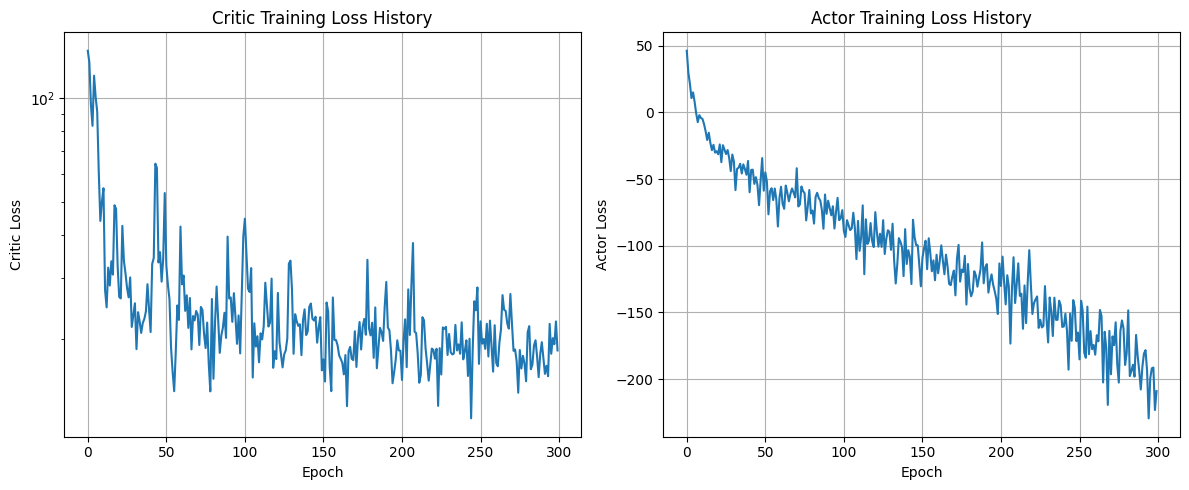

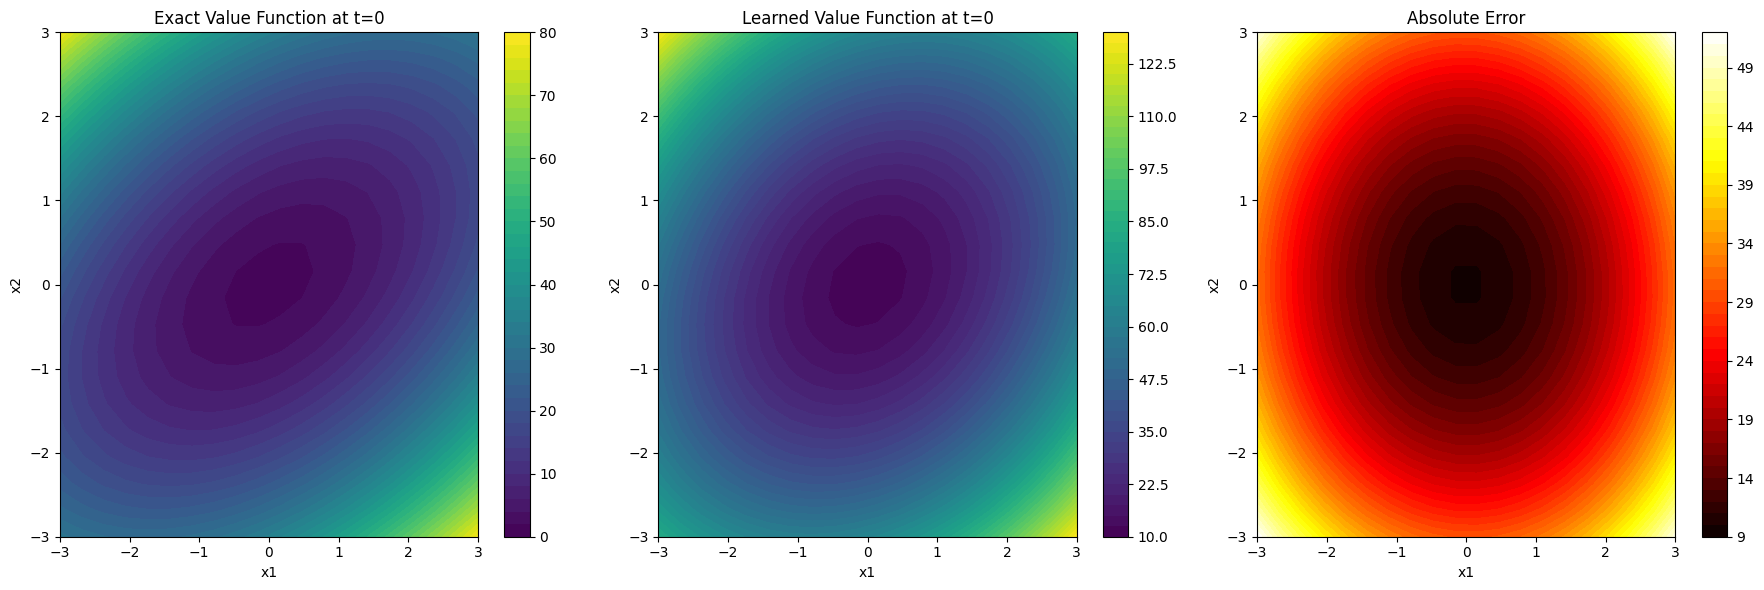

Initial state [2. 2.]:
  Learned policy final cost: 19.82
  Optimal policy final cost: 12.51
  Cost ratio: 1.58
Initial state [ 2. -2.]:
  Learned policy final cost: 25.49
  Optimal policy final cost: 22.47
  Cost ratio: 1.13
Initial state [-2. -2.]:
  Learned policy final cost: 18.03
  Optimal policy final cost: 8.89
  Cost ratio: 2.03
Initial state [-2.  2.]:
  Learned policy final cost: 36.34
  Optimal policy final cost: 35.08
  Cost ratio: 1.04


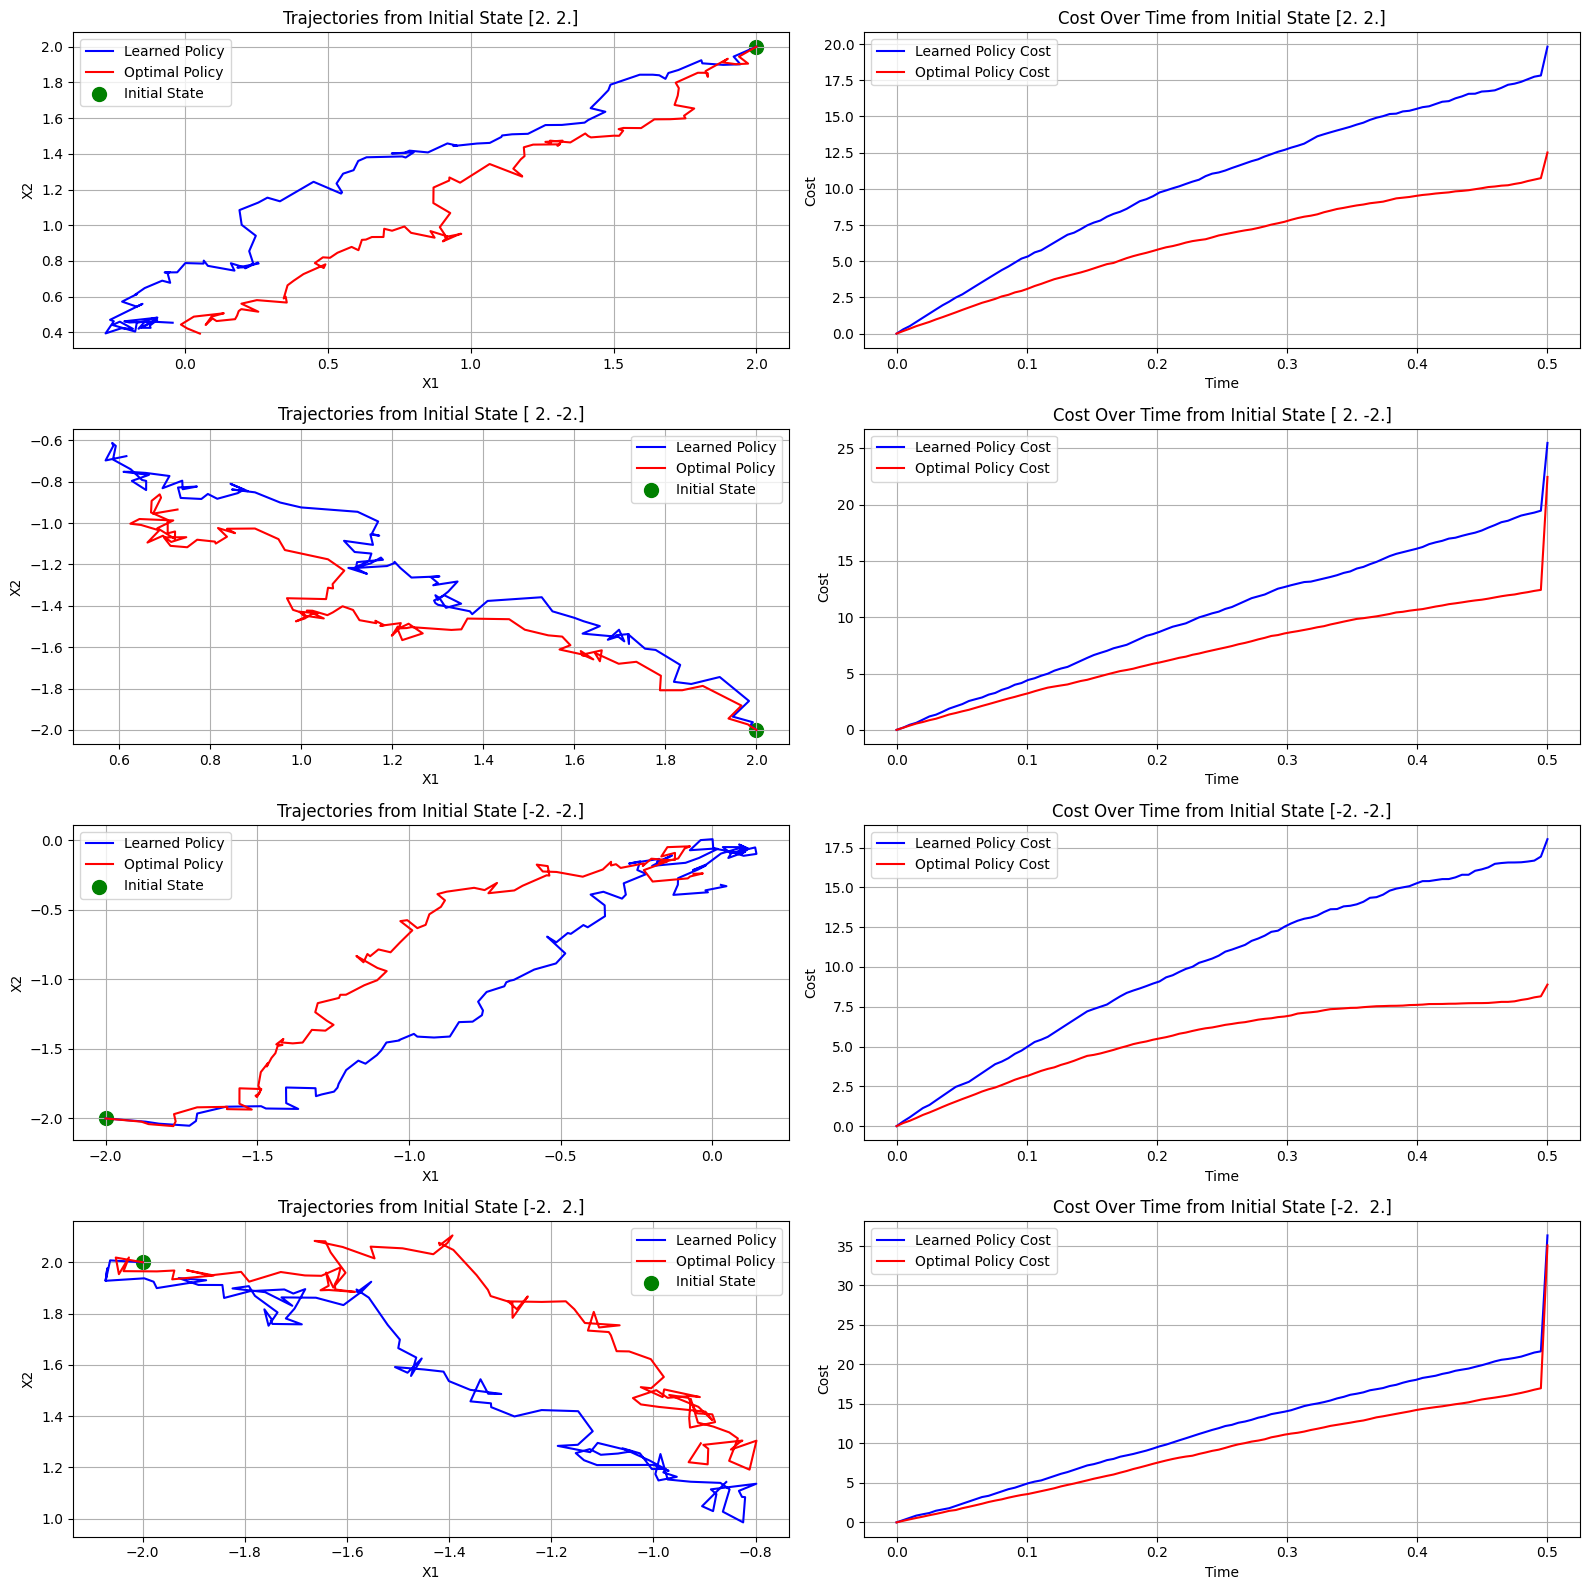

Final value function error: 1.768128e+01
Final policy error: 1.342509e+01


In [52]:
run_actor_critic_algorithm()